In [1]:
%config Completer.use_jedi = False
import sys, os
sys.path.append('../pyecog2')
sys.path.append('../')
from ProjectClass import Project,FileBuffer,MainModel
# from pyecog2.main import MainModel
import json
import feature_extractor 
import importlib
importlib.reload(feature_extractor)
FeatureExtractor = feature_extractor.FeatureExtractor

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import spectrotools as spec
importlib.reload(spec)
from numba import jit, njit
import timeit

from scipy import stats
import json


In [2]:
import colorsys

In [3]:
import pyqtgraph as pg

In [4]:
from scipy.signal import get_window
import classifier
from scipy import linalg

In [5]:
main_model = MainModel()
project=Project(main_model=main_model)
project.load_from_json('/media/mfpleite/LaCie_1/ML_pyecog_2/ClassifierCVProject.pyecog')
fe = FeatureExtractor()

ProjectClass set_current_animal start
AnnotationPage copy_from start
copy from - history reset
AnnotationPage copy_from finished in 0.000203231000341475 seconds
AnnotationPage copy_from start
copy from - history reset
AnnotationPage copy_from finished in 4.134600021643564e-05 seconds
ProjectClass set_current_animal ran in 0.0011357780022080988 seconds
ProjectClass set_current_animal start
AnnotationPage copy_from start
copy from - history reset
AnnotationPage copy_from finished in 6.004799797665328e-05 seconds
AnnotationPage copy_from start
copy from - history reset
AnnotationPage copy_from finished in 3.3524000173201784e-05 seconds
ProjectClass set_current_animal ran in 0.002068014000542462 seconds
looking for 35
ProjectClass set_current_animal start
AnnotationPage copy_from start
copy from - history reset
AnnotationPage copy_from finished in 5.7166002079611644e-05 seconds
AnnotationPage copy_from start
copy from - history reset
AnnotationPage copy_from finished in 0.00213379700289806

In [6]:
project.project_file

'/media/mfpleite/LaCie_1/ML_pyecog_2/ClassifierCVProject.pyecog'

In [7]:
annotation0 = project.current_animal.annotations.annotations_list[1]
it = project.current_animal.eeg_init_time
index = [i  for i in range(len(it)) if (0<(annotation0.getStart()-it[i])<3600) ][0]
# index=0
fname = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1]+['features'])
# fname ='/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566408624_2019-08-21-18-30-24_tids_[119].features'

f_vec = np.fromfile(fname,dtype='float64')

fmeta_file = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1] + ['fmeta'])
fmeta_dict = json.load(open(fmeta_file))


In [8]:
f_vec = f_vec.reshape((-1,fe.number_of_features))
f_vec[np.where(np.isnan(f_vec))] = 0

In [9]:
starts = [(annotation0.getStart()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]
ends = [(annotation0.getEnd()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]

f_labels = np.zeros(len(f_vec),dtype='bool')
for i in range(len(starts)-1) :
    s = int(np.floor(starts[i+1]))
    e = int(np.ceil(ends[i+1]))
    f_labels[s:e] = 1
    
f_vec_d  = np.hstack([f_vec,np.vstack([np.zeros(f_vec.shape[1]),np.diff(f_vec,axis=0)])])
f_vec_d  = f_vec
f_vec_d = f_vec_d-np.mean(f_vec_d,axis=0)
f_vec_d = f_vec_d/np.std(f_vec_d,axis = 0)

blanks = f_vec_d#[(1-f_labels).nonzero()[0],:]
seizures = f_vec_d[(f_labels).nonzero()[0],:]

blanks_mu  = blanks.mean(axis=0)
blanks_cov = (blanks-blanks_mu).T.dot((blanks-blanks_mu))/blanks.shape[0]
seizures_mu  = seizures.mean(axis=0)
seizures_cov = (seizures-seizures_mu).T.dot((seizures-seizures_mu))/seizures.shape[0]

[Text(0, 0, 'min'),
 Text(0, -1, 'max'),
 Text(0, -2, 'mean'),
 Text(0, -3, 'log std'),
 Text(0, -4, 'kurtosis'),
 Text(0, -5, 'skewness'),
 Text(0, -6, 'log coastline (log sum of abs diff)'),
 Text(0, -7, 'log power in band (1, 4) Hz'),
 Text(0, -8, 'log power in band (4, 8) Hz'),
 Text(0, -9, 'log power in band (8, 12) Hz'),
 Text(0, -10, 'log power in band (12, 30) Hz'),
 Text(0, -11, 'log power in band (30, 50) Hz'),
 Text(0, -12, 'log power in band (50, 70) Hz'),
 Text(0, -13, 'log power in band (70, 120) Hz'),
 Text(0, -14, 'Spectrum entropy')]

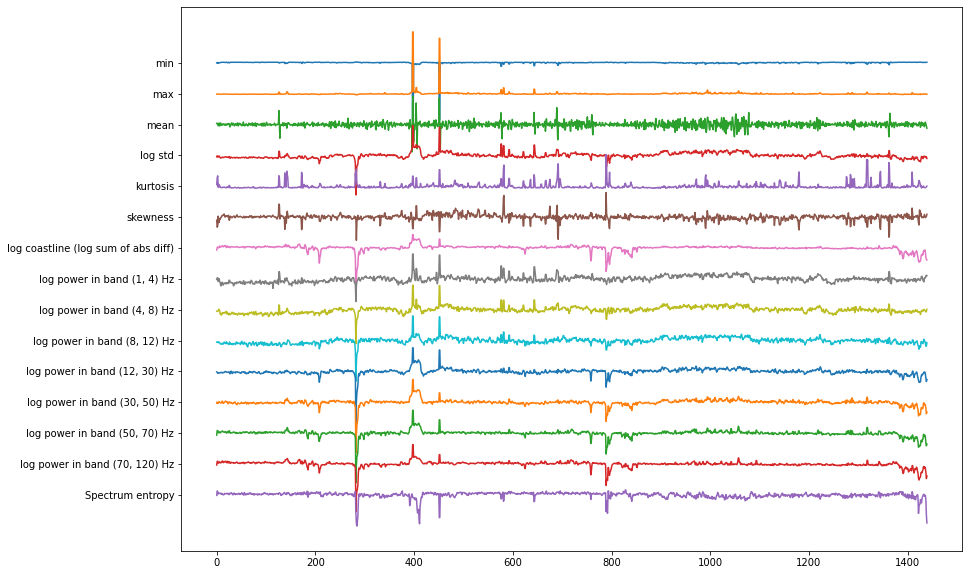

In [13]:

f = plt.figure(figsize=(14,10))
ax = f.gca()
spec.plot_spread(f_vec_d,.5);

# plt.xlim([400,1000])
# plt.vlines(starts[1:],-15,0)
# plt.vlines(ends[1:],-15,0)
ax.set_yticks(range(0,-fe.number_of_features,-1))
ax.set_yticklabels(fe.settings['feature_labels'])

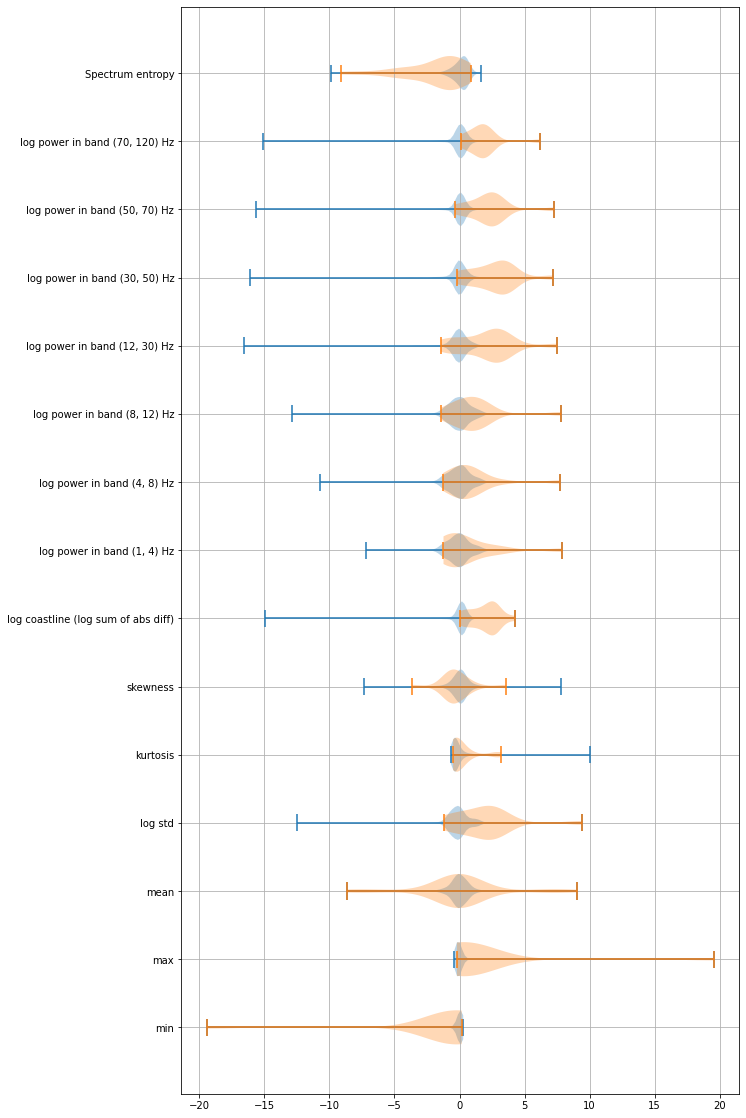

In [14]:
plt.figure(figsize=(10,20))
plt.violinplot(blanks,vert=False);
plt.violinplot(seizures,vert=False);
ax=plt.gca()
# ax.set_yticks(list(range(1,fe.number_of_features+1,1)) + 
#               list(range(fe.number_of_features+1,2*fe.number_of_features+1,1)))
# ax.set_yticklabels(fe.settings['feature_labels'] + ['d'+s+'/dt' for s in fe.settings['feature_labels']])
ax.set_yticks(list(range(1,fe.number_of_features+1,1)))
ax.set_yticklabels(fe.settings['feature_labels'])
plt.grid()

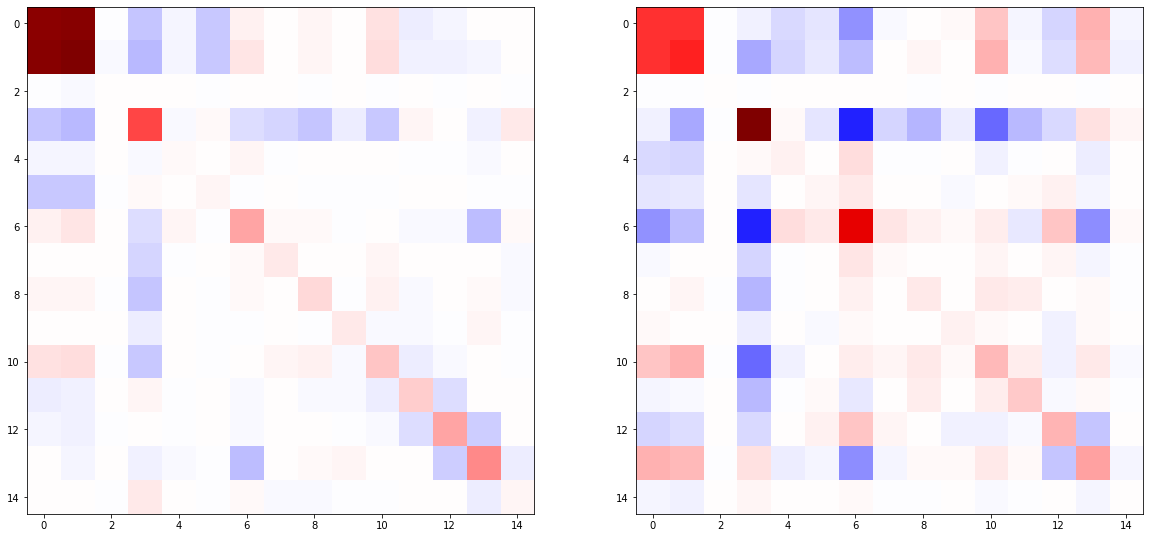

In [15]:
blanks_cov_i = np.linalg.inv(blanks_cov)
seizures_cov_i = np.linalg.inv(seizures_cov)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(blanks_cov_i,cmap='seismic',vmin=-np.max(np.abs(blanks_cov_i)),vmax=np.max(np.abs(blanks_cov_i)))
plt.subplot(1,2,2)
plt.imshow(seizures_cov_i,cmap='seismic',vmin=-np.max(np.abs(seizures_cov_i)),vmax=np.max(np.abs(seizures_cov_i)))

In [16]:
fe.settings['feature_labels']

['min',
 'max',
 'mean',
 'log std',
 'kurtosis',
 'skewness',
 'log coastline (log sum of abs diff)',
 'log power in band (1, 4) Hz',
 'log power in band (4, 8) Hz',
 'log power in band (8, 12) Hz',
 'log power in band (12, 30) Hz',
 'log power in band (30, 50) Hz',
 'log power in band (50, 70) Hz',
 'log power in band (70, 120) Hz',
 'Spectrum entropy']

In [17]:
@jit(nopython=True)
def MVGD_LL_jit(fdata,mu,inv_cov,LL,no_scale):
    k = fdata.shape[1]
    N = fdata.shape[0]
    scale = (1-no_scale)*((-k/2)*np.log(2*np.pi)+1/2*np.log(np.linalg.det(inv_cov[:,:])))
    for i in range(N):
        LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)

def MVGD_LL(fdata,mu,inv_cov,no_scale = False):
    LL = np.zeros(fdata.shape[0])
    MVGD_LL_jit(fdata,mu,inv_cov,LL, no_scale)
    return LL

@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

<ipython-input-17-da9e4bc747e3>:7: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)
/home/mfpleite/anaconda3/envs/pyecog2/lib/python3.8/site-packages/numba-0.52.0-py3.8-linux-x86_64.egg/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


(-500.0, 400.0)

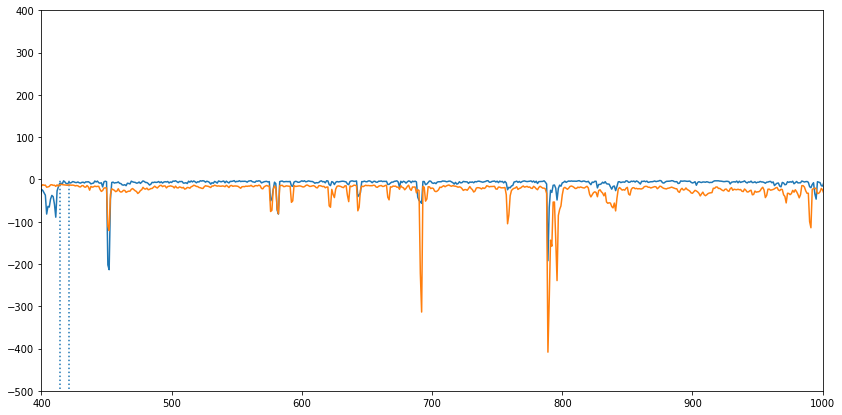

In [18]:
blanks_cov_i = np.linalg.inv(blanks_cov)
blanks_cov_ir = np.linalg.inv(blanks_cov+np.eye(len(blanks_cov))*blanks_cov.diagonal()/len(blanks))

seizures_cov_i = np.linalg.inv(seizures_cov)
seizures_cov_ir = np.linalg.inv(seizures_cov+np.eye(len(seizures_cov))*seizures_cov.diagonal()/len(seizures))

b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir)
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir)

plt.figure(figsize=(14,7))
# plt.plot(b_LL)
plt.plot(b_LLr)
# plt.plot(s_LL)
plt.plot(s_LLr)
plt.vlines(starts[1:],-2000,0,linestyles=':')
plt.vlines(ends[1:],-2000,0,linestyles=':')

plt.xlim(400,1000)
plt.ylim(-500,400)

(400.0, 1000.0)

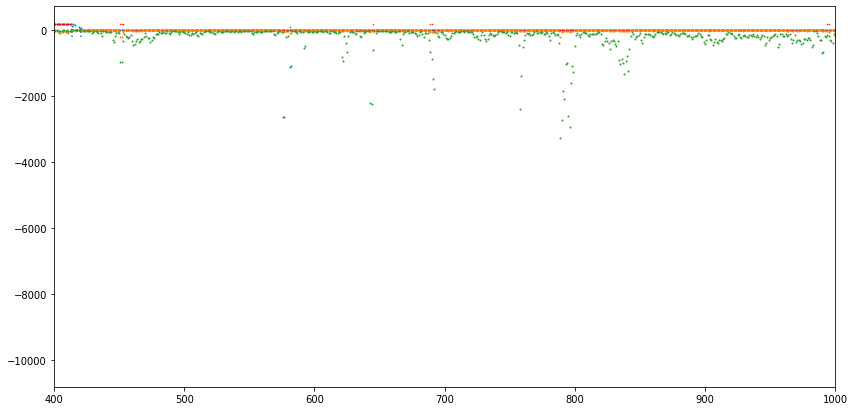

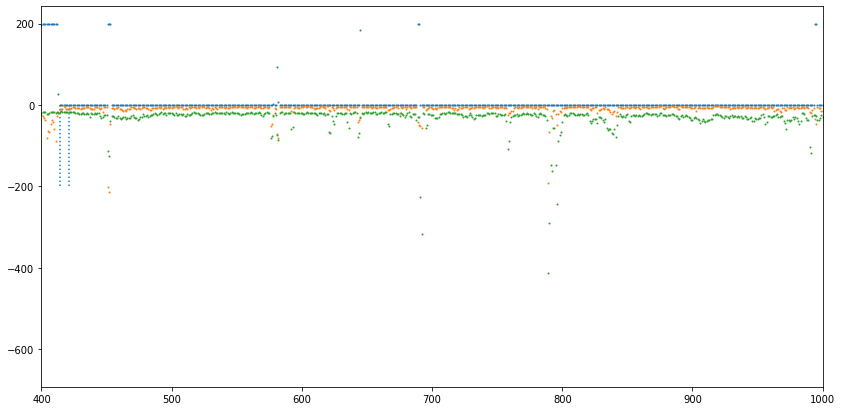

In [19]:
blanks_LL = MVGD_LL(blanks,blanks_mu,blanks_cov_i,no_scale=True)
seizures_LL = MVGD_LL(seizures,seizures_mu,seizures_cov_i,no_scale=True)

blank_bias = np.log(len(blanks)/(len(blanks)+len(seizures)))
seizure_bias = np.log(len(seizures)/(len(blanks)+len(seizures)))


b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)+ blank_bias
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)+ seizure_bias
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir) + blank_bias
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir) + seizure_bias

LL = np.array([b_LL.T,s_LL.T]).T
p  = LL2prob(LL) 

LLr = np.array([b_LLr.T,s_LLr.T]).T
pr  = LL2prob(LLr) 

plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(pr[:,1]*200,'.',markersize=1,color = [1,0,0,1])
plt.plot(b_LL,'.',markersize=2)
plt.plot(s_LL,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
plt.xlim(400,1000)

plt.figure(figsize=(14,7))
plt.plot(pr[:,1]*200,'.',markersize=2)
plt.plot(b_LLr,'.',markersize=2)
plt.plot(s_LLr,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
plt.xlim(400,1000)

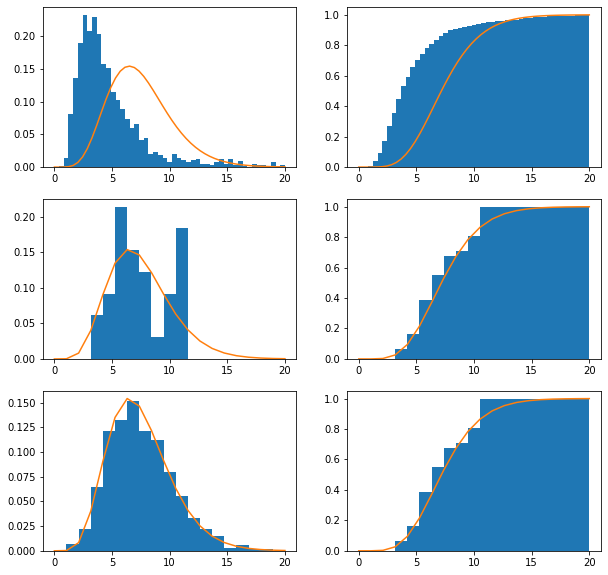

In [20]:
plt.figure(figsize=(10,10))
dof = f_vec.shape[1]
x = np.linspace(0,20,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
plt.subplot(321)
plt.hist(-blanks_LL,bins = x,density = True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(322)
plt.hist(-blanks_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)

x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(323)
plt.hist(-seizures_LL,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(324)
plt.hist(-seizures_LL,bins = x,density=True,cumulative=True);
plt.plot(x,cum_chi2)


f_rand = np.random.randn(*f_vec.shape)
LL_rand = 0.5*np.sum(f_rand**2,axis = 1)
x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(325)
plt.hist(LL_rand,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(326)
plt.hist(-seizures_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)





In [7]:
import classifier
from scipy import linalg

importlib.reload(classifier)

<module 'classifier' from '/home/mfpleite/PycharmProjects/pyecog2/Notebooks/../pyecog2/classifier.py'>

In [8]:
PGC = classifier.ProjectClassifier(project=project)

loading /media/mfpleite/LaCie_1/ML_pyecog_2/ClassifierCVProject.pyecog_classifier
Could not load imported classifier
Could not load feature extractor


In [9]:
print(PGC.global_classifier.class_npoints,PGC.global_classifier.blank_npoints)

[18672  5756   158   144] 64012632


In [10]:
print(PGC.imported_classifier.class_npoints,PGC.imported_classifier.blank_npoints)

[0 0 0 0 0] 0


In [11]:
PGC.assimilate_global_classifier()

assimilating 119
assimilating 120
assimilating 141
assimilating 17
assimilating 28
assimilating 33
assimilating 35


In [12]:
GC = classifier.GaussianClassifier(project,fe)
GC.copy_from(PGC.animal_classifier_dict['119'])
GC.labels2classify

array(['seizure', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming'],
      dtype='<U16')

In [13]:
for k,c in PGC.animal_classifier_dict.items():
    _,_,npts = c.all_mu_and_cov()
    print(k,npts)

119 9835143
120 9720524
141 5483384
17 9904236
28 9723347
33 9715976
35 9654752


In [14]:
GC = classifier.GaussianClassifier(project,fe)
GC.copy_re_normalized_classifier(PGC.global_classifier)

In [15]:
GC.all_mu_and_cov()[2] - PGC.animal_classifier_dict['119'].all_mu_and_cov()[2]

54202219

In [16]:
GC = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])
GC2 = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])
GC3 = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])

In [17]:
project.current_animal.annotations.labels

['seizure(ELE)',
 'repetitive 4IEDs',
 'Theta rhytm',
 'Grooming',
 '(auto)seizure',
 'seizure']

In [18]:
GC = classifier.GaussianClassifier(project,fe)

In [19]:
GC.train(project.animal_list[:1])

Training with animal: 119
Training with classes: ['seizure' 'Grooming' 'seizure(ELE)' 'repetitive 4IEDs' 'Theta rhytm']
Transitions:file: 1709 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572561642_2019-10-31-22-40-42_tids_[119].featuresof 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567939759_2019-09-08-11-49-19_tids_[119].features of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1568191759_2019-09-11-09-49-19_tids_[119].features file: 567 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1568450959_2019-09-14-09-49-19_tids_[119].features
 [[ 0. 81.  6.  0. 10.  5.]
 [ 0.  0.  0. 81.  0.  0.]
 [ 6.  0.  0.  0.  0.  0.]
 [81.  0.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.  0.]
 [ 5.  0.  0.  0.  0.  0.]]


In [20]:
GC2.train(project.animal_list[1:2])

Training with animal: 120
Training with classes: ['seizure' 'repeated IIEDs']
Transitions:file: 1691 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572561642_2019-10-31-22-40-42_tids_[120].features1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1567964959_2019-09-08-18-49-19_tids_[120].features file: 766 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1569232159_2019-09-23-10-49-19_tids_[120].featuresof 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1571021359_2019-10-14-03-49-19_tids_[120].features1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572554442_2019-10-31-20-40-42_tids_[120].features
 [[  0. 130.   0.]
 [130.   0.   0.]
 [  0.   0.   0.]]


In [21]:
GC3.train(project.animal_list[1:2])

Training with animal: 120
Training with classes: ['seizure' 'repeated IIEDs']
Transitions:file: 1690 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572558042_2019-10-31-21-40-42_tids_[120].featuresile: 839 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1569494959_2019-09-26-11-49-19_tids_[120].features file: 1122 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1570513759_2019-10-08-06-49-19_tids_[120].features of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1571269759_2019-10-17-00-49-19_tids_[120].features1691 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572561642_2019-10-31-22-40-42_tids_[120].features
 [[  0. 130.   0.]
 [130.   0.   0.]
 [  0.   0.   0.]]


In [22]:
GC2.copy_re_normalized_classifier(GC)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [23]:
mu3,W3,iW3 = GC3.whitening_mu_W_iW()
mu2,W2,iW2 = GC2.whitening_mu_W_iW()
mu,W,iW = GC.whitening_mu_W_iW()

IndexError: index 2 is out of bounds for axis 0 with size 2

NameError: name 'W' is not defined

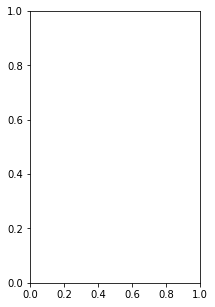

In [24]:
plt.figure(figsize=(14,5))
plt.subplot(1,4,1)
plt.imshow(np.log(np.abs(W)))
plt.subplot(1,4,2)
plt.imshow(np.log(np.abs(W2)))
plt.subplot(1,4,3)
plt.imshow(np.log(np.abs(W3)))
plt.subplot(1,4,4)
plt.plot(mu3)
plt.plot(mu2)
plt.plot(mu)

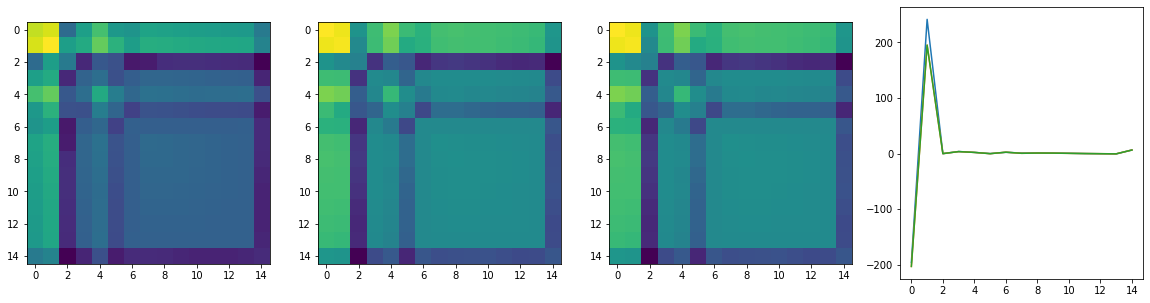

In [25]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.subplot(1,4,2)
plt.imshow(np.log(np.abs(GC2.blank_cov)))
plt.subplot(1,4,3)
plt.imshow(np.log(np.abs(GC3.blank_cov)))
plt.subplot(1,4,4)
plt.plot(GC.blank_means)
plt.plot(GC2.blank_means)
plt.plot(GC3.blank_means)

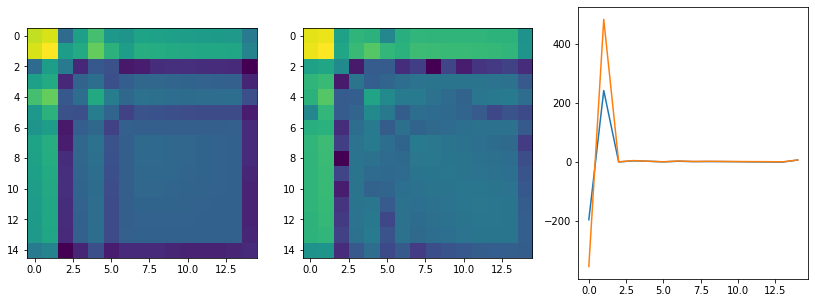

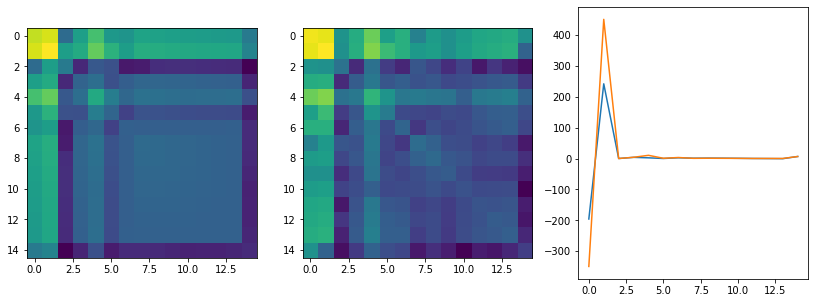

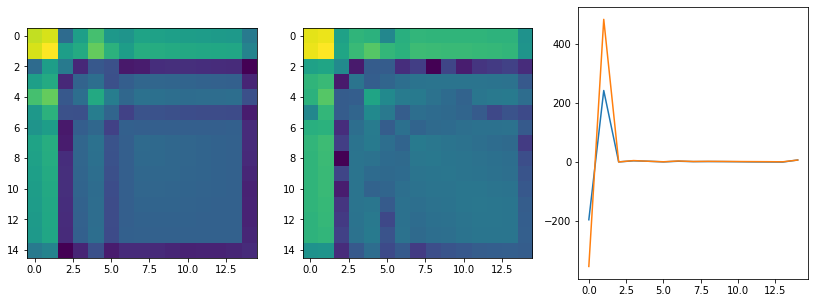

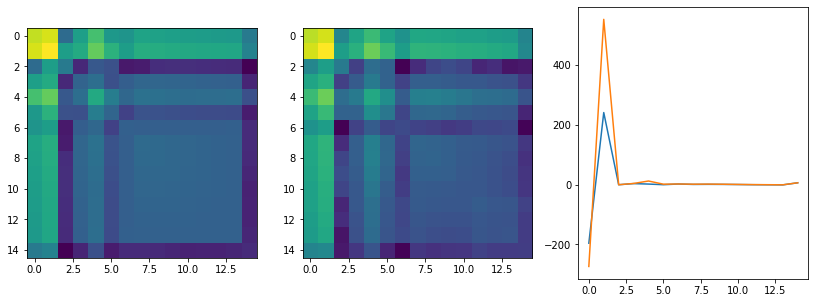

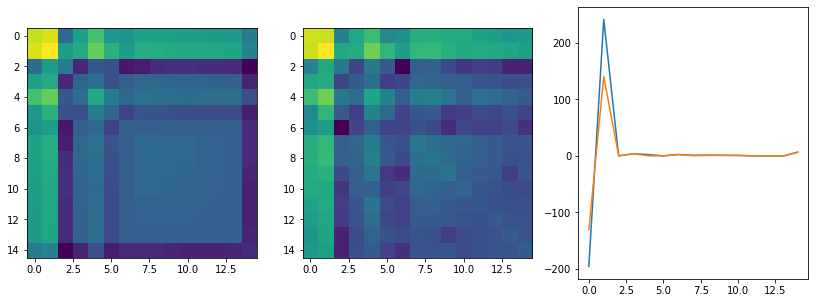

In [26]:
mu = GC.blank_means[:,np.newaxis]
cov = GC.blank_cov
npoints = GC.blank_npoints
for i in range(len(GC.labels2classify)):
    muc = GC.class_means[i][:,np.newaxis]
    covc = GC.class_cov[i]
    npointsc = GC.class_npoints[i]
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(np.log(np.abs(cov)))
    plt.subplot(1,3,2)
    plt.imshow(np.log(np.abs(covc)))
    plt.subplot(1,3,3)
    plt.plot(mu)
    plt.plot(muc)
    mu,cov = classifier.average_mu_and_cov(mu,cov,npoints,muc,covc,npointsc)
    npoints += npointsc

In [27]:
npoints

array(12297061)

In [28]:
GC.blank_npoints

array(12297061)

In [29]:
GC.class_means

array([[-3.53644285e+02,  4.82313744e+02, -9.20463849e-04,
         4.52093582e+00,  2.21355450e+00,  5.17264718e-01,
         3.08524260e+00,  1.46198737e+00,  1.92184874e+00,
         1.62948686e+00,  1.29823123e+00,  1.02117860e+00,
         7.58222169e-01,  3.92685260e-01,  6.32715946e+00],
       [-3.49050350e+02,  4.50022140e+02,  2.05556174e-03,
         3.97505254e+00,  1.03054377e+01,  7.43397093e-01,
         3.23002174e+00,  5.96537968e-01,  8.91996626e-01,
         6.75322831e-01,  4.76395562e-01,  1.99747830e-01,
         1.98230572e-01,  1.32361455e-01,  6.51890901e+00],
       [-3.53644285e+02,  4.82313744e+02, -9.20463849e-04,
         4.52093582e+00,  2.21355450e+00,  5.17264718e-01,
         3.08524260e+00,  1.46198737e+00,  1.92184874e+00,
         1.62948686e+00,  1.29823123e+00,  1.02117860e+00,
         7.58222169e-01,  3.92685260e-01,  6.32715946e+00],
       [-2.73542064e+02,  5.53588722e+02,  4.32826003e-03,
         4.27758381e+00,  1.24288296e+01,  1.81518587

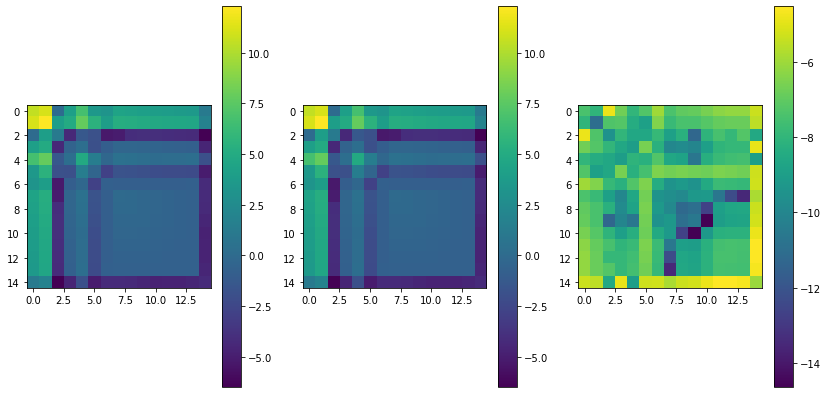

In [30]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(cov)))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(GC.blank_cov-cov))-np.log(np.abs(GC.blank_cov)))
# plt.imshow(np.log(np.abs(A)))
plt.colorbar()

In [31]:
A = linalg.sqrtm(classifier.reg_invcov(GC.blank_cov,GC.blank_npoints))

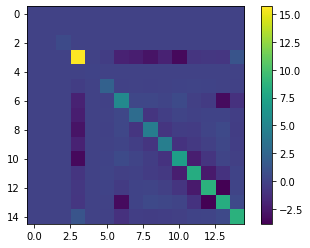

In [32]:
plt.imshow(A)
plt.colorbar()

In [33]:
error = A@GC.blank_cov@A.T - np.eye(GC.Ndim)

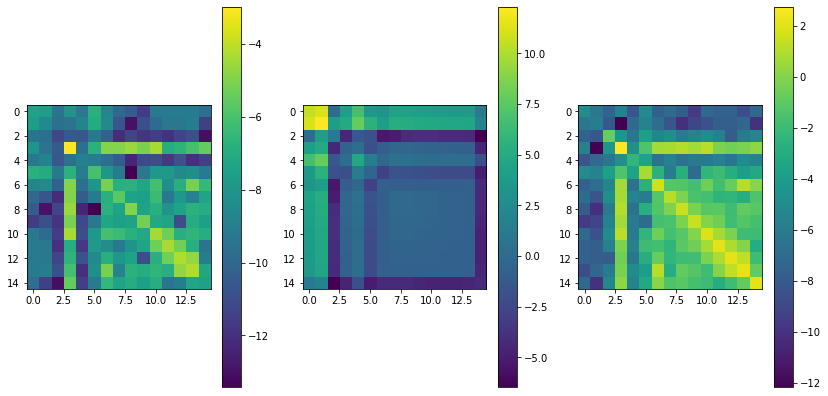

In [34]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(error)))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(A)))
plt.colorbar()


In [35]:
# GC2._debug_f_vec_d.shape

In [36]:
# f = plt.figure(figsize=(14,10))
# ax = f.gca()
# spec.plot_spread(GC2._debug_f_vec_d[:,-4:],.5);

In [37]:
import spectrotools as spec

(-5.0, 8.0)

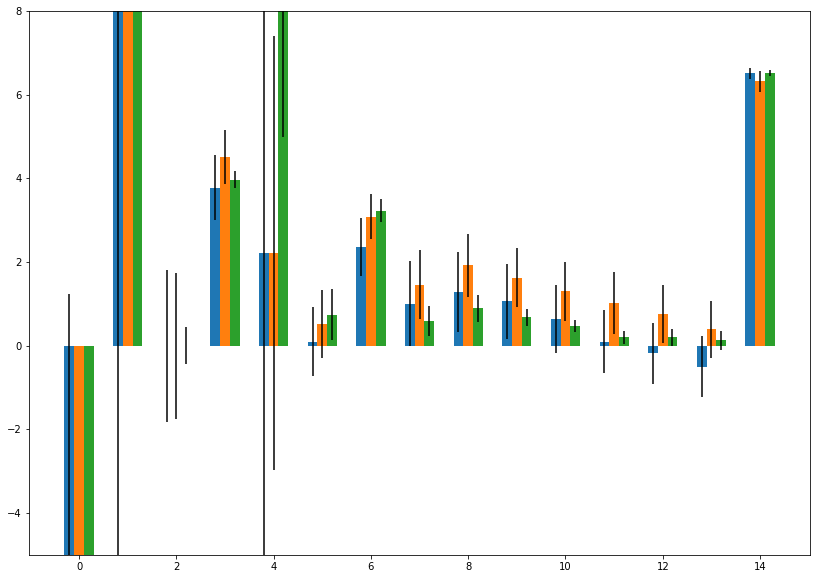

In [38]:
plt.figure(figsize=(14,10))
blank_std = np.sqrt(np.diag(GC.blank_cov))
class_std0 = np.sqrt(np.diag(GC.class_cov[0]))
class_std1 = np.sqrt(np.diag(GC.class_cov[1]))
# plt.plot(GC.blank_means[:],'k')
# plt.plot(GC.blank_means[:]+blank_std,'k:')
# plt.plot(GC.blank_means[:]-blank_std,'k:')
# plt.ylim([-10,10])
# plt.plot(GC.class_means[0,:],'b')
# plt.plot(GC2.class_means[0,:],'b:')
plt.bar(np.arange(GC.Ndim)-.2,GC.blank_means[:],yerr=blank_std,width=.2)
plt.bar(np.arange(GC.Ndim),GC.class_means[0,:],yerr=class_std0,width=.2)
plt.bar(np.arange(GC.Ndim)+.2,GC.class_means[1,:],yerr=class_std1,width=.2)
plt.ylim([-5,8])

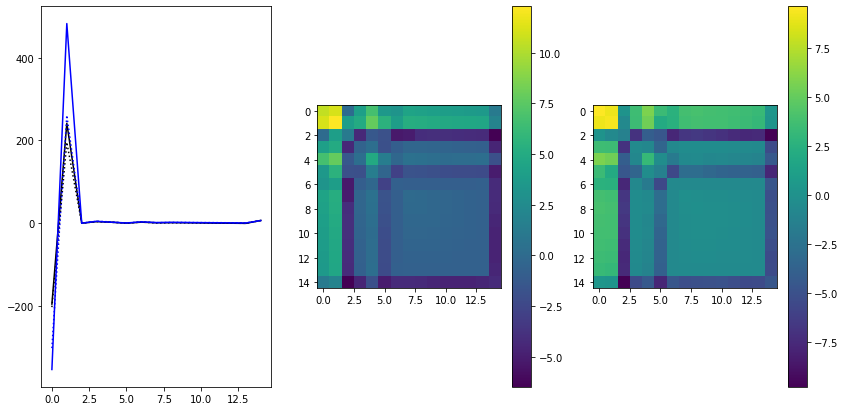

In [39]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.plot(GC.blank_means,'k')
plt.plot(GC2.blank_means,'k:')
plt.plot(GC.class_means[0,:],'b')
plt.plot(GC2.class_means[0,:],'b:')
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(GC2.blank_cov)))
plt.colorbar()


In [40]:
project.set_current_animal(project.animal_list[0])

ProjectClass set_current_animal start
AnnotationPage copy_from start
copy from - history reset
AnnotationPage copy_from finished in 0.0008017889995244332 seconds
AnnotationPage copy_from start
copy from - history reset
AnnotationPage copy_from finished in 0.002821791000314988 seconds
ProjectClass set_current_animal ran in 0.00435986700176727 seconds


In [41]:
project.animal_list[0].id

'119'

In [42]:
PGC = classifier.ProjectClassifier(project=project)

PGC.assimilate_global_classifier(labels2train=['seizure', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming']) # ['repetitive 4IEDs', 'seizure'])
GC = classifier.GaussianClassifier(project,fe)
GC.copy_from(PGC.animal_classifier_dict[project.current_animal.id])

loading /media/mfpleite/LaCie_1/ML_pyecog_2/ClassifierCVProject.pyecog_classifier
Could not load imported classifier
Could not load feature extractor
assimilating 119
assimilating 120
assimilating 141
assimilating 17
assimilating 28
assimilating 33
assimilating 35


In [43]:
GC.copy_re_normalized_classifier(PGC.global_classifier)

In [44]:
PGC.global_classifier.transitions_matrix

array([[  0., 648.,  50.,   5.,   7.],
       [648.,   3.,   0.,   0.,   0.],
       [ 50.,   0.,   0.,   0.,   0.],
       [  5.,   0.,   0.,   0.,   0.],
       [  7.,   0.,   0.,   0.,   0.]])

In [45]:
GC.transitions_matrix

array([[  0., 648.,  50.,   5.,   7.],
       [648.,   3.,   0.,   0.,   0.],
       [ 50.,   0.,   0.,   0.,   0.],
       [  5.,   0.,   0.,   0.,   0.],
       [  7.,   0.,   0.,   0.,   0.]])

In [46]:
PGC.global_classifier.labels2classify

array(['seizure', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming'],
      dtype='<U16')

In [47]:
(LLv,R2v,pf,timev) = GC.classify_animal(project.current_animal,max_annotations=100)
# LLv = LLv[::10,:]
# R2v = R2v[::10,:]
# pf = pf[::10,:]
# timev = timev[::10]

/home/mfpleite/PycharmProjects/pyecog2/Notebooks/../pyecog2/classifier.py:25: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  LL[i] =( scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T))[0,0]  # the [0,0] is for numba wizzardry to work
/home/mfpleite/anaconda3/envs/pyecog2PySide/lib/python3.8/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  warnings.warn(NumbaPerformanceWarning(msg))


Animal: 119 file: 1709 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572561642_2019-10-31-22-40-42_tids_[119].fmeta119 file: 520 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1568281759_2019-09-12-10-49-19_tids_[119].fmeta 119 file: 836 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1569419359_2019-09-25-14-49-19_tids_[119].fmeta 119 file: 849 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1569466159_2019-09-26-03-49-19_tids_[119].fmeta /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1569610159_2019-09-27-19-49-19_tids_[119].fmeta of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1570106959_2019-10-03-13-49-19_tids_[119].fmeta 119 file: 1221 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1570805359_2019-10-11-15-49-19_tids_[119].fmeta 119 file: 1288 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1571046559_2019-10-14-10-49-19_tids_[119].fmeta 11

annotation already exists at 317275 317305
annotation already exists at 339860 339990
annotation already exists at 352218 352349
annotation already exists at 559078 559188
annotation already exists at 564505 564649
annotation already exists at 645916 645972
annotation already exists at 697074 697271
annotation already exists at 749105 749237
Found 935 putative events. Saving 100 with highest confidence score
labels before delete ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure']
labels after ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure']
found color for  repetitive 4IEDs [12, 242, 242]
(auto)repetitive 4IEDs (7, 157, 157) ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure']
add label
(auto)repetitive 4IEDs None ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure', '(auto)repetitive 4IEDs']
Annotations: Label already exists
ad

annotation already exists at 650571 650624
annotation already exists at 667778 667828
annotation already exists at 689135 689214
annotation already exists at 784976 785013
Found 14473 putative events. Saving 100 with highest confidence score
labels before delete ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure', '(auto)repetitive 4IEDs']
labels after ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure', '(auto)repetitive 4IEDs']
found color for  Theta rhytm [12, 12, 242]
(auto)Theta rhytm (7, 7, 157) ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure', '(auto)repetitive 4IEDs']
add label
(auto)Theta rhytm None ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure', '(auto)repetitive 4IEDs', '(auto)Theta rhytm']
Annotations: Label already exists
add annotation
(auto)Theta rhytm None ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', '

annotation already exists at 1216672 1216723
annotation already exists at 1248597 1248660
annotation already exists at 1441183 1441229
annotation already exists at 1461697 1461742
annotation already exists at 1532826 1532949
annotation already exists at 2282819 2282912
Found 10419 putative events. Saving 100 with highest confidence score
labels before delete ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure', '(auto)repetitive 4IEDs', '(auto)Theta rhytm']
labels after ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure', '(auto)repetitive 4IEDs', '(auto)Theta rhytm']
found color for  Grooming [242, 12, 242]
(auto)Grooming (157, 7, 157) ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure', '(auto)repetitive 4IEDs', '(auto)Theta rhytm']
add label
(auto)Grooming None ['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', 'seizure', '(auto)seizure', '(auto)repetitive

In [150]:
import hmm_pyecog
from classifier import transitions2rates
from scipy.stats import chi2
importlib.reload(hmm_pyecog)
HMM_LL = hmm_pyecog.HMM_LL

In [151]:
hmm = HMM_LL()
hmm.A = transitions2rates(GC.transitions_matrix, GC.blank_npoints, GC.class_npoints)

_, _, total_npoints = GC.all_mu_and_cov()
th = chi2.isf(1/total_npoints,GC.Ndim,scale=0.5)
LLth = np.diag(GC.log_likelyhoods(np.vstack((GC.blank_means, GC.class_means)), bias=False)) - th
# Now will regularize LLv for extreme values and compensate HMMfor repeated observations because of overlap of Feature extractor
LLv_reg = np.maximum(LLth, LLv)*(1-GC.overlap)*.5 # TEMPORARY 0.5 FACTOR!

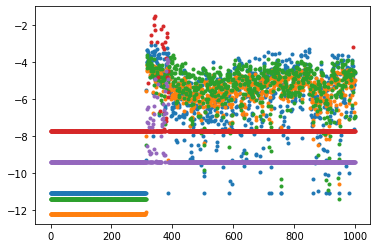

In [152]:
plt.plot(LLv_reg[:1000,:],'.')

In [153]:
GC.labels2classify

array(['seizure', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming'],
      dtype='<U16')

In [154]:
MLp, T1, T2 = hmm.viterbi(LLv_reg.T)

Viterbi (jit) 5 2461208


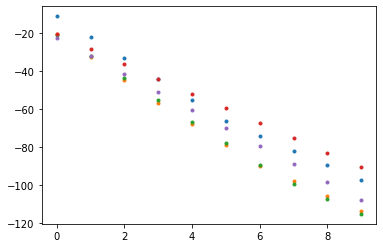

In [155]:
plt.plot(T1[:,:10].T,'.')

In [160]:
[sum(MLp.ravel()==i) for i in range(5)]

[1734009, 7528, 53090, 326757, 339824]

In [138]:
logA = np.log(hmm.A)
t=4

/tmp/ipykernel_13176/2365199280.py:1: RuntimeWarning: divide by zero encountered in log
  logA = np.log(hmm.A)


In [139]:
(T1[:,t-1] + logA[:,1])

array([-25.58575172, -56.91662654,         -inf,         -inf,
               -inf])

In [149]:
T1[:,:4]

array([[-11.06153448, -22.12269384, -33.18385321, -14.08505142],
       [-20.33710391, -32.56917694, -44.80124996, -56.88129989],
       [-20.73383896, -32.15942331, -43.58500766, -55.01059202],
       [-20.64848737, -28.41674968, -36.185012  ,   0.        ],
       [-22.41384744, -31.87236335,   0.        ,   0.        ]])

In [24]:
# (LLv,R2v,pf,timev) = GC2.classify_animal(project.animal_list[1],max_annotations=100)

In [20]:
# project.save_to_json(fname = project.project_file[:-7]+'_test.pyecog')

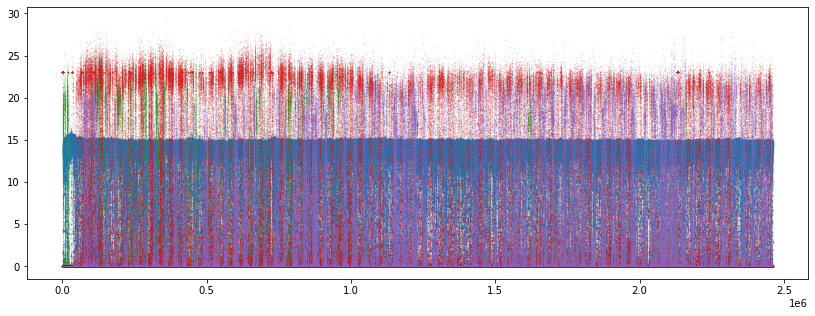

In [89]:
plt.figure(figsize=(14,5))
plt.plot(-np.log(1-pf.T),'.', markersize=.1)
# plt.ylim(-100,50)

In [25]:
 _, _, total_npoints = GC.all_mu_and_cov()
th = stats.chi2.isf(1/total_npoints,GC.Ndim,scale=0.5)
print(1/total_npoints,th)

1.5615883739870483e-08 33.467012688661924


In [26]:
GC.labels2classify

array(['seizure', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming'],
      dtype='<U16')

In [27]:
starts = np.array([a.getStart() for a in project.current_animal.annotations.annotations_list if a.getLabel() =='seizure(ELE)'])
ends = np.array([a.getEnd() for a in project.current_animal.annotations.annotations_list if a.getLabel() =='seizure(ELE)'])

In [28]:
starts

array([1.56646099e+09, 1.56646139e+09, 1.56646160e+09, 1.56675572e+09,
       1.56675603e+09, 1.56676588e+09, 1.56682517e+09, 1.56682533e+09,
       1.56682549e+09, 1.56684095e+09, 1.56684114e+09, 1.56684138e+09,
       1.56684173e+09, 1.56684199e+09, 1.56748118e+09, 1.56748159e+09,
       1.56748184e+09, 1.56749051e+09, 1.56749039e+09, 1.56749007e+09,
       1.56749065e+09, 1.56749025e+09, 1.56749088e+09, 1.56749958e+09,
       1.56751133e+09, 1.56751154e+09, 1.56751181e+09, 1.56751198e+09,
       1.56752336e+09, 1.56752374e+09, 1.56752401e+09, 1.56752430e+09,
       1.56752464e+09, 1.56834494e+09, 1.56834424e+09, 1.56835425e+09,
       1.56835454e+09, 1.56835474e+09, 1.56835519e+09, 1.56881970e+09,
       1.56881957e+09, 1.56916917e+09, 1.56916951e+09, 1.56916985e+09,
       1.56919832e+09, 1.56919865e+09, 1.56919895e+09, 1.56919942e+09,
       1.56985277e+09, 1.56985311e+09, 1.57012055e+09, 1.57012091e+09,
       1.57012121e+09, 1.57038560e+09, 1.57071302e+09, 1.57071320e+09,
      

In [29]:
len(starts)

81

In [30]:
K = 1

In [31]:
import numpy as np

self = GC
_, _, total_npoints = GC.all_mu_and_cov()
th = stats.chi2.isf(1/(total_npoints),GC.Ndim,scale=0.5)
LLth = np.diag(GC.log_likelyhoods(np.vstack((GC.blank_means, GC.class_means)), bias=False)) - th
LLv_reg = np.maximum(LLth, LLv)*(1-self.overlap)*K
# LLv_reg = LLv_reg*(1-fe.settings['overlap'])

from hmm_pyecog import HMM_LL
from classifier import transitions2rates
hmm = HMM_LL()
hmm.A = transitions2rates(GC.transitions_matrix, GC.blank_npoints, GC.class_npoints)

# pf = hmm.forward_backward(LLv.T)
hmm.forward_backward(LLv_reg.T)

HMM:forward
HMM:backward


array([[1.67761360e-05, 8.89023658e-09, 6.06586600e-12, ...,
        9.99990923e-01, 9.99945370e-01, 9.99449807e-01],
       [1.15787666e-14, 9.74943240e-19, 1.77008752e-22, ...,
        9.00773374e-06, 5.42302937e-05, 3.89843857e-04],
       [4.75291615e-15, 1.73023393e-18, 6.33497081e-22, ...,
        6.89687907e-08, 1.93647775e-07, 7.25421378e-07],
       [9.99983224e-01, 9.99999991e-01, 1.00000000e+00, ...,
        5.65246634e-11, 2.05809743e-07, 1.52358491e-04],
       [6.68506126e-14, 2.24169701e-15, 7.51138452e-17, ...,
        5.15063871e-14, 8.44219914e-11, 7.26485207e-06]])

In [32]:
GC.transitions_matrix

array([[  0., 648.,  50.,   5.,   7.],
       [648.,   3.,   0.,   0.,   0.],
       [ 50.,   0.,   0.,   0.,   0.],
       [  5.,   0.,   0.,   0.,   0.],
       [  7.,   0.,   0.,   0.,   0.]])

In [33]:
ab = (hmm.alpha + hmm.beta).T
ab = ab-ab.max(axis=1,keepdims=True)
log_not_posterior = np.log(np.exp(ab)@(np.ones((ab.shape[1],ab.shape[1])) - np.eye(ab.shape[1]))) \
                    - np.log(np.exp(ab)@(np.ones((ab.shape[1],ab.shape[1]))))

In [34]:
len(log_not_posterior.ravel()) - np.sum(np.isfinite(log_not_posterior))

0

In [35]:
log_not_posterior[~np.isfinite(log_not_posterior)]= -1000

In [36]:
k = np.where(GC.labels2classify == 'seizure')[0]+1

<IPython.core.display.Javascript object>


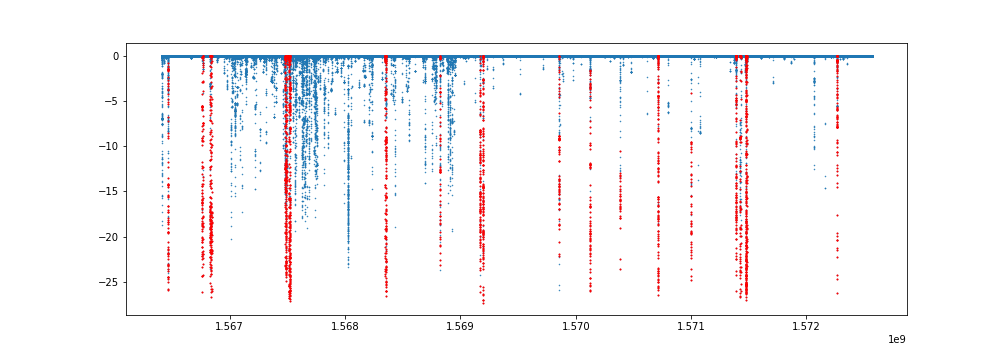

In [33]:
%matplotlib notebook
plt.figure(figsize=(14,5))
plt.plot(timev,log_not_posterior[:,k],'.', markersize=1,alpha=1)
# plt.ylim(-70,10)
# plt.legend()

for s,e in zip(starts,ends):
    indices = np.array((timev>s)*(timev<e)).astype('bool')
    lps = log_not_posterior[indices,k]
    plt.plot(timev[indices],lps,'r.',markersize=2)

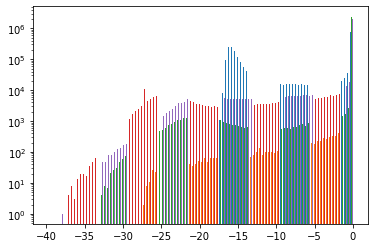

In [37]:
%matplotlib inline
plt.hist(log_not_posterior,bins=100,log=True);

In [38]:
from annotations_module import AnnotationElement
from classifier import intervals_overlap

self = GC
animal = project.current_animal
max_annotations = 100000
labels2annotate = ['seizure']

for i2,label in enumerate(self.labels2classify):
    if label not in labels2annotate: # ignore labels that are not in labels2annotate
        continue
    i = i2+1
    print(i,label)
    starts = np.nonzero(np.diff(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int')) > 0)[0] + 1
    ends = np.nonzero(np.diff(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int')) < 0)[0] + 1
    alist = []
    print('len starts',len(starts))
    manual_label_positions = [a.getPos() for a in animal.annotations.get_all_with_label(label)]
    ELEmanual_label_positions = [a.getPos() for a in animal.annotations.get_all_with_label(label+'(ELE)')]
    ELEmanual_label_positions_c = - np.ones(len(ELEmanual_label_positions))*np.inf
    print('manual label positions:',manual_label_positions)
    for j in range(len(starts)):
        if True:#not any([intervals_overlap([timev[starts[j]],timev[ends[j]]],pos) for pos in manual_label_positions]):
            if ends[j]-starts[j]<1:
                print('interval too small:',starts[j],ends[j])
                continue
            # c = np.sum(LLv[starts[j]:ends[j],i])-np.sum(LLv[starts[j]:ends[j],0])
            # c = np.sum(np.log(pf[i,starts[j]:ends[j]])-np.log(np.maximum(1-pf[i,starts[j]:ends[j]],1e-12)))
            # c = np.sum(-np.log(np.maximum(1-pf[i,starts[j]:ends[j]],1e-12)))
            # c = np.max(-np.log(np.maximum(1-pf[i,starts[j]:ends[j]],2**-50)))
            # c = np.max(LLv_reg[starts[j]:ends[j], i])
            # c = np.mean(R2v[starts[j]:ends[j], i])
            c = np.max( - log_not_posterior[starts[j]:ends[j], i])
            # print('start,end,confidence', starts[j], ends[j],c)
            a = AnnotationElement(label='(auto)'+label,start=timev[starts[j]],end=timev[ends[j]],confidence=c)
            o = any([intervals_overlap([timev[starts[j]],timev[ends[j]]],pos) for pos in ELEmanual_label_positions])
            if o:
                k = np.where([intervals_overlap([timev[starts[j]],timev[ends[j]]],pos) for pos in ELEmanual_label_positions])[0][0]
                ELEmanual_label_positions_c[k] = max(ELEmanual_label_positions_c[k],c)
            alist.append((c,o,a))
        else:
            print('annotation already exists at', starts[j], ends[j])

    print('Found',len(alist), 'putative events. Saving',max_annotations,'withh highest confidence score')
    alist.sort(key=lambda c:-c[0])
#     animal.annotations.delete_label('(auto)'+label)  # Delete all previous auto generated labels 
#     try:
#         old_color = animal.annotations.label_color_dict[label]
#         print('found color for ', label, old_color)
#     except Exception:
#         print('did not find color for' , label)
#         old_color = (255,255,255)
#     new_color = tuple([ max(int(c*0.65),0) for c in old_color])
#     animal.annotations.add_label('(auto)'+label,color = new_color)

#     animal.annotations.pause_history_cache(True)
#     for c,a in alist[:max_annotations]:
#         animal.annotations.add_annotation(a)
#     animal.annotations.pause_history_cache(False)

1 seizure
len starts 364
manual label positions: [[1566460986.23, 1566461047.58], [1566461388.72, 1566461448.31], [1566461602.04, 1566461667.65], [1566755716.47, 1566755840.36], [1566756029.09, 1566756084.63], [1566765881.59, 1566765982.91], [1566825169.58, 1566825256.89], [1566825334.47, 1566825394.87], [1566825486.86, 1566825556.22], [1566840953.62, 1566841033.67], [1566841135.52, 1566841208.13], [1566841381.95, 1566841439.67], [1566841733.78, 1566841781.89], [1566841993.98, 1566842052.8], [1567481182.32, 1567481278.77], [1567481589.62, 1567481628.97], [1567481835.68, 1567481899.51], [1567490508.48, 1567490558.21], [1567490389.5, 1567490425.84], [1567490071.08, 1567490195.68], [1567490654.25, 1567490716.44], [1567490246.38, 1567490297.85], [1567490884.74, 1567490956.18], [1567499581.61, 1567499673.72], [1567511328.59, 1567511438.22], [1567511540.06, 1567511603.19], [1567511811.26, 1567511871.9], [1567511975.4, 1567512047.61], [1567523357.17, 1567523475.04], [1567523736.79, 1567523801

In [39]:
k

80

In [40]:
labelv = np.zeros(len(LLv),dtype='int')

for i2,label in enumerate(self.labels2classify):
    manual_label_positions = [a.getPos() for a in animal.annotations.get_all_with_label(label)]
    for s,e in manual_label_positions:
        labelv[(s<timev)*(timev<e)] = i2+1
    
#     ELEmanual_label_positions = [a.getPos() for a in animal.annotations.get_all_with_label(label+'(ELE)')]
#     ELEmanual_label_positions_c = - np.ones(len(ELEmanual_label_positions))*np.inf
#     print('manual label positions:',manual_label_positions)
#     for j in range(len(starts)):
#         if not any([intervals_overlap([timev[starts[j]],timev[ends[j]]],pos) for pos in manual_label_positions]):
#             if ends[j]-starts[j]<1:
#                 print('interval too small:',starts[j],ends[j])
#                 continue
#             # c = np.sum(LLv[starts[j]:ends[j],i])-np.sum(LLv[starts[j]:ends[j],0])
#             # c = np.sum(np.log(pf[i,starts[j]:ends[j]])-np.log(np.maximum(1-pf[i,starts[j]:ends[j]],1e-12)))
#             # c = np.sum(-np.log(np.maximum(1-pf[i,starts[j]:ends[j]],1e-12)))
#             # c = np.max(-np.log(np.maximum(1-pf[i,starts[j]:ends[j]],2**-50)))
#             # c = np.max(LLv_reg[starts[j]:ends[j], i])
#             # c = np.mean(R2v[starts[j]:ends[j], i])
#             c = np.max( - log_not_posterior[starts[j]:ends[j], i])
#             # print('start,end,confidence', starts[j], ends[j],c)
#             a = AnnotationElement(label='(auto)'+label,start=timev[starts[j]],end=timev[ends[j]],confidence=c)
#             o = any([intervals_overlap([timev[starts[j]],timev[ends[j]]],pos) for pos in ELEmanual_label_positions])
#             if o:
#                 k = np.where([intervals_overlap([timev[starts[j]],timev[ends[j]]],pos) for pos in ELEmanual_label_positions])[0]
#                 ELEmanual_label_positions_c[k] = max(ELEmanual_label_positions_c[k],c)
#             alist.append((c,o,a))
#         else:
#             print('annotation already exists at', starts[j], ends[j])

#     print('Found',len(alist), 'putative events. Saving',max_annotations,'withh highest confidence score')
#     alist.sort(key=lambda c:-c[0])

<ipython-input-41-7dc6e80e2e68>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-41-7dc6e80e2e68>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


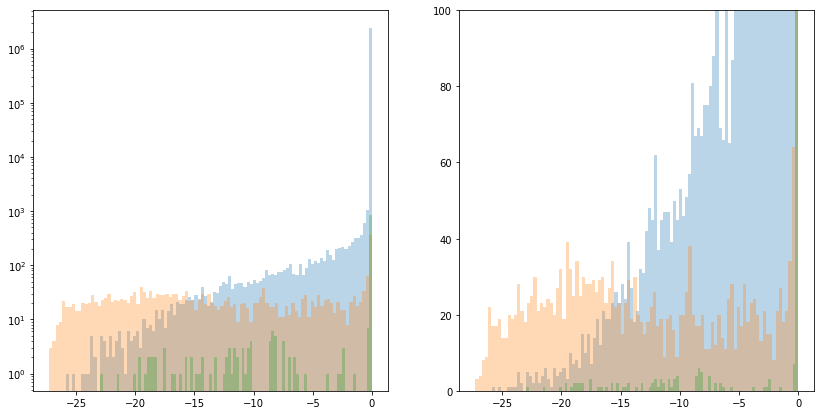

In [41]:
nlabels = len(self.labels2classify)+1
plt.figure(figsize=(14,7))
for l in range(nlabels):
    lp_class = log_not_posterior[labelv==l,1]
#     plt.figure()
#     plt.title(l)
    plt.subplot(1,2,1)
    plt.hist(lp_class,bins=100,log=True,alpha=.3)
    plt.subplot(1,2,2)
    plt.hist(lp_class,bins=100,log=False,alpha=.3)
    plt.ylim(0,100)

<ipython-input-42-7dc6e80e2e68>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-42-7dc6e80e2e68>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


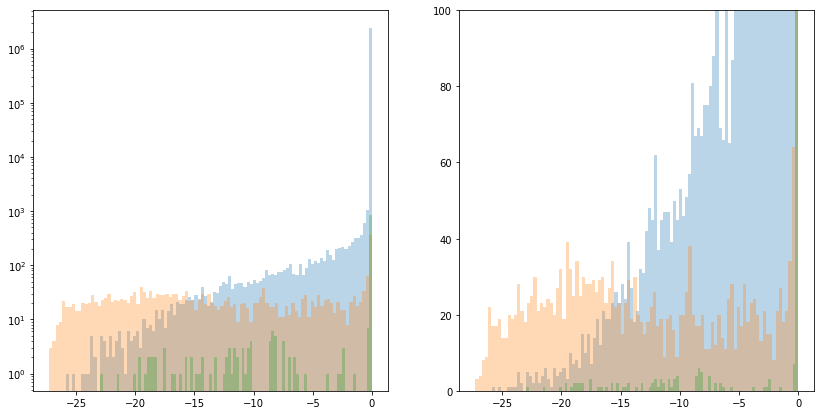

In [42]:
nlabels = len(self.labels2classify)+1
plt.figure(figsize=(14,7))
for l in range(nlabels):
    lp_class = log_not_posterior[labelv==l,1]
#     plt.figure()
#     plt.title(l)
    plt.subplot(1,2,1)
    plt.hist(lp_class,bins=100,log=True,alpha=.3)
    plt.subplot(1,2,2)
    plt.hist(lp_class,bins=100,log=False,alpha=.3)
    plt.ylim(0,100)

In [43]:
K

1

In [44]:
classv = np.argmax(LLv,axis=1)

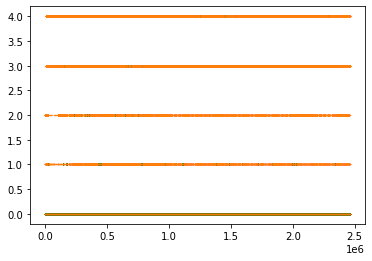

In [45]:
plt.plot(labelv,'.',markersize=.1)
plt.plot(classv,'.',markersize=.1)

In [46]:
LLv_reg_original = LLv_reg.copy()

In [47]:
# LLv_reg = LLv_reg[::10,:]
# labelv = labelv[::10]
# classv = classv[::10]

In [48]:
LLv_true = LLv_reg[np.arange(len(LLv_reg)),labelv]
LLv_max  = LLv_reg[np.arange(len(LLv_reg)),classv]
pz = np.array([np.mean(labelv==l) for l in range(len(self.labels2classify)+1)]).reshape((-1,1))

In [49]:
# pz = 0*pz + 1/len(pz)

In [50]:
k = 1

In [51]:
pykpz = pz.T*np.exp(LLv_reg*k)
LLpykpz = LLv_reg*(pykpz)
spykpz = np.sum(pykpz,axis=1,keepdims=True)
dk = np.mean(np.sum(LLpykpz/spykpz,axis=1))-np.mean(LLv_true)
ddk = np.mean(np.sum(
    LLv_reg*LLpykpz/spykpz +
    - LLpykpz/(spykpz**2)*np.sum(LLpykpz,axis=1,keepdims=True)
    ,axis=1,keepdims=True))

k1 = k - dk/ddk
print(dk,ddk)
print(k,k1,k-k1,sep='\n')
k=k1

0.08290505137009685 0.35444483665973603
1
0.7660988599766655
0.2339011400233345


In [52]:
K=k

In [53]:
(LLv_reg*((pz.T*np.exp(LLv_reg)**k)/((np.exp(LLv_reg)**k)@pz))).shape

(2461208, 5)

In [54]:
ra = []
rb = []
dra= []
drb = []
r=[]
dr = []
kv = np.linspace(0.5,0.6,21)

for k in kv:
    pykpz = pz.T*np.exp(LLv_reg*k)
#     a = 
    r.append(np.mean(-k*LLv_true.reshape((-1,1)) + np.log(np.sum(pykpz,axis=1,keepdims=True))))
    dk = np.mean(np.sum(LLv_reg*(pykpz)/np.sum(pykpz,axis=1,keepdims=True),axis=1))-np.mean(LLv_true)
#     dr.append(-np.mean(LLv_true) + np.mean((np.sum(LLv_reg*((pz.T*np.exp(LLv_reg*k))),axis=1,keepdims=True)/((np.exp(LLv_reg*k))@pz))))
    dr.append(dk)
    print(k)
r = np.array(r)
dr = np.array(dr)


0.5
0.505
0.51
0.515
0.52
0.525
0.53
0.535
0.54
0.545
0.55
0.5549999999999999
0.5599999999999999
0.565
0.57
0.575
0.58
0.585
0.59
0.595
0.6


In [55]:
((np.exp(LLv_reg)**k)@pz).shape

(2461208, 1)

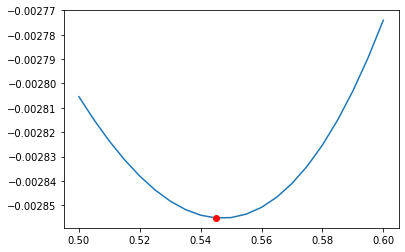

In [56]:
%matplotlib inline
plt.plot(kv,r)
plt.plot(kv[np.argmin(r)],np.min(r),'ro')

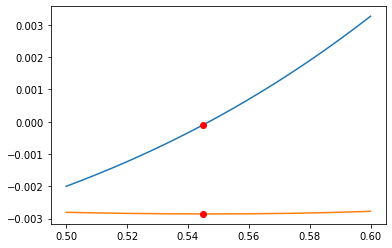

In [57]:

plt.plot(kv,dr)
plt.plot(kv[np.argmin(abs(dr))],dr[np.argmin(abs(dr))],'ro')
plt.plot(kv,r)
plt.plot(kv[np.argmin(r)],np.min(r),'ro')

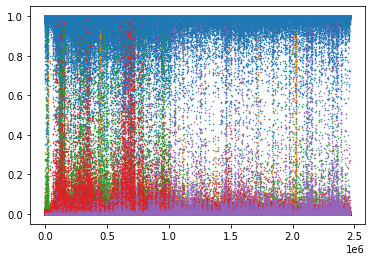

In [56]:
plt.plot(((pz.T*np.exp(LLv_reg*K))/((np.exp(LLv_reg*K))@pz)),'.',markersize=1)

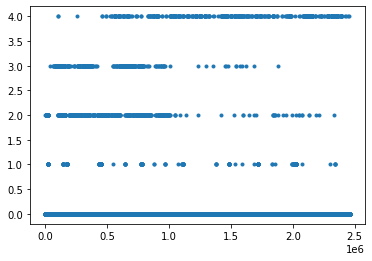

In [57]:
classv = np.argmax(((pz.T*np.exp(LLv_reg*K))/((np.exp(LLv_reg*K))@pz)),axis=1)
plt.plot(classv,'.')

In [58]:
self.labels2classify

array(['seizure', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming'],
      dtype='<U16')

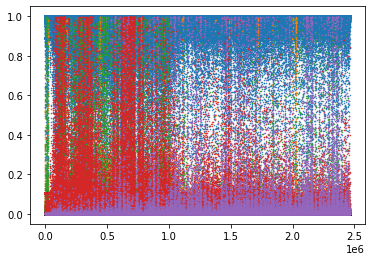

In [59]:
plt.plot(((pz.T*np.exp(LLv_reg)**1)/((np.exp(LLv_reg)**1)@pz)),'.',markersize=1)

In [60]:
plt.close('all')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [61]:
from matplotlib.lines import Line2D
for variable in dir():
    v = eval(variable)
    if (type(v) is list) and v and type(v[0]) is Line2D:
        print(variable,type(v))
        v[0].figure.clf()
        plt.close(v[0].figure)

_21 <class 'list'>
_43 <class 'list'>
_54 <class 'list'>
_55 <class 'list'>
_56 <class 'list'>
_57 <class 'list'>
_59 <class 'list'>


In [62]:
import gc
gc.collect()

94812

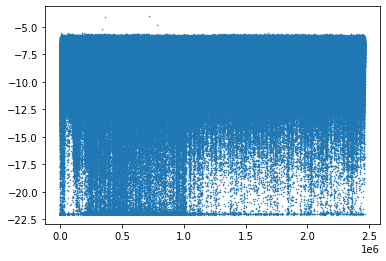

In [63]:
plt.plot(np.sum(LLv_reg*((pz.T*np.exp(LLv_reg)**k)/((np.exp(LLv_reg)**k)@pz)),axis=1),'.',markersize=1)

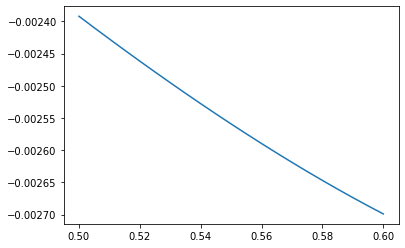

In [94]:
plt.plot(kv,r)

In [65]:
np.log((np.exp(LLv)**k)@pz).shape

<ipython-input-65-a394fd107989>:1: RuntimeWarning: divide by zero encountered in log
  np.log((np.exp(LLv)**k)@pz).shape


(2461208, 1)

In [66]:
kv = np.linspace(0,1,20)

In [67]:
labelv = np.zeros(len(LLv))

In [68]:
labelv[]

SyntaxError: invalid syntax (<ipython-input-68-3e9c9ee767a4>, line 1)

In [69]:
self.labels2classify

array(['seizure', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming'],
      dtype='<U16')

In [70]:
alist

[(27.275820560753804,
  True,
  {'label': '(auto)seizure', 'start': 1569198596.5, 'end': 1569198731.5, 'confidence': 27.275820560753804, 'notes': ''}),
 (27.11602763831782,
  True,
  {'label': '(auto)seizure', 'start': 1567524304.0, 'end': 1567524371.5, 'confidence': 27.11602763831782, 'notes': ''}),
 (26.94308886304214,
  True,
  {'label': '(auto)seizure', 'start': 1571479221.5, 'end': 1571479291.5, 'confidence': 26.94308886304214, 'notes': ''}),
 (26.86923363432457,
  True,
  {'label': '(auto)seizure', 'start': 1567523686.5, 'end': 1567523801.5, 'confidence': 26.86923363432457, 'notes': ''}),
 (26.770263537630026,
  True,
  {'label': '(auto)seizure', 'start': 1567511809.0, 'end': 1567511866.5, 'confidence': 26.770263537630026, 'notes': ''}),
 (26.717617537828602,
  True,
  {'label': '(auto)seizure', 'start': 1567511531.5, 'end': 1567511596.5, 'confidence': 26.717617537828602, 'notes': ''}),
 (26.705831494184864,
  True,
  {'label': '(auto)seizure', 'start': 1571427456.5, 'end': 15714

In [66]:
cv,ov,av = zip(*alist)
FPR = np.cumsum(1-np.array(ov))/sum(ov)
TPR = np.array([sum(ELEmanual_label_positions_c>=c) for c in cv])/len(ELEmanual_label_positions_c)

In [67]:
cv2,ov2,av2 = zip(*alist)
FPR2 = np.cumsum(1-np.array(ov2))/sum(ov2)
TPR2 = np.array([sum(ELEmanual_label_positions_c>=c) for c in cv2])/len(ELEmanual_label_positions_c)

Text(0.5, 0, 'False Positives / Positives')

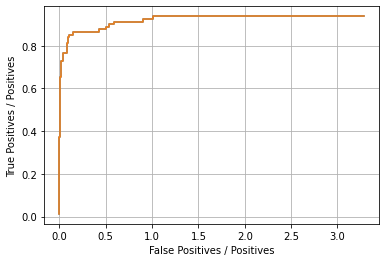

In [68]:
plt.plot(FPR,TPR)
plt.plot(FPR2,TPR2)
plt.grid(True)
plt.ylabel('True Positives / Positives')
plt.xlabel('False Positives / Positives')

In [62]:
len(cv2)

364

<ipython-input-62-6d7d47433848>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(1-hmm.posterior[1:,:].T),'.', markersize=1,alpha=.1)


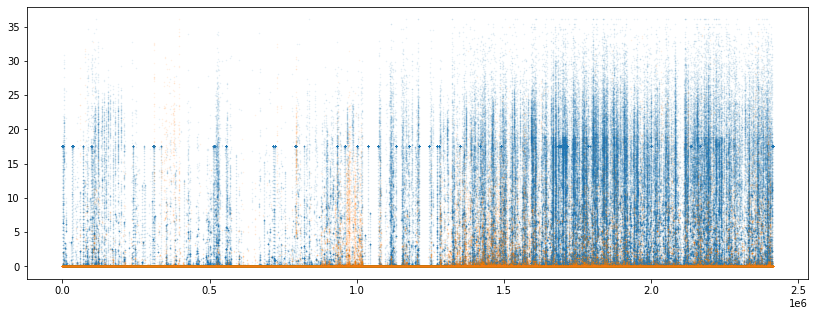

In [62]:
plt.figure(figsize=(14,5))
plt.plot(-np.log(1-hmm.posterior[1:,:].T),'.', markersize=1,alpha=.1)
# plt.ylim(-100,50)

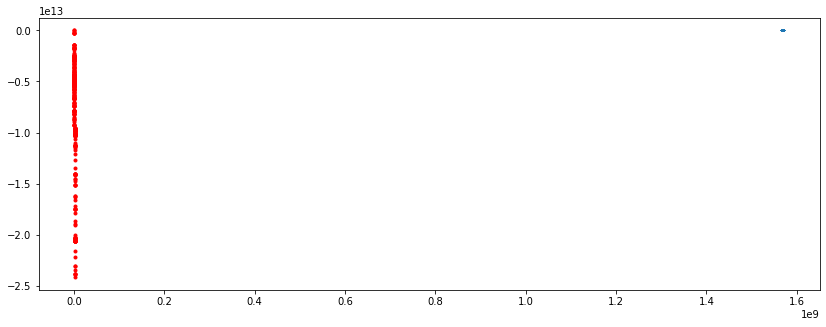

In [81]:
plt.figure(figsize=(14,5))
plt.plot(starts,starts*(hmm.alpha[1,0].T + hmm.beta[1,0].T),'r.')
plt.plot(timev, hmm.alpha[1,:].T + hmm.beta[1,:].T,'.', markersize=1,alpha = .1)

In [44]:
GC.labels2classify

array(['seizure', 'repeated IIEDs'], dtype='<U14')

In [91]:
th = stats.chi2.isf(1e-3,GC.Ndim,scale=0.5)

In [92]:
th

18.848649109176915

In [112]:
len(R2v)

2461208

In [111]:
i=1
np.sum(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int'))/len(R2v)

0.005620817094694963

<IPython.core.display.Javascript object>


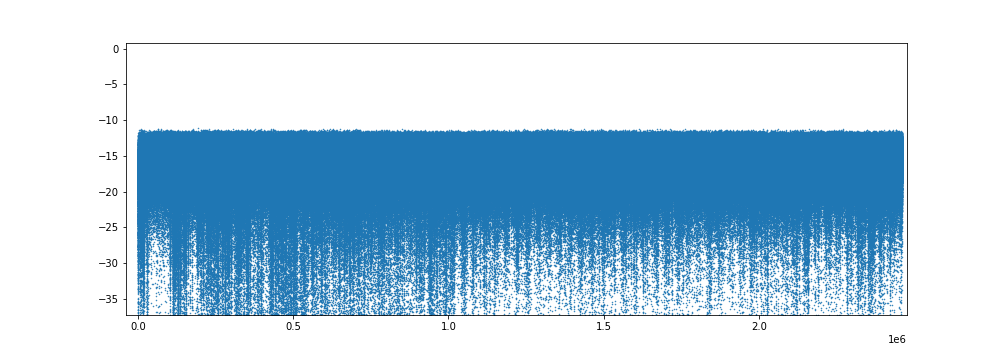

In [57]:
%matplotlib notebook
plt.figure(figsize=(14,5))
plt.plot(R2v[:,0],'.', markersize=1)

<IPython.core.display.Javascript object>


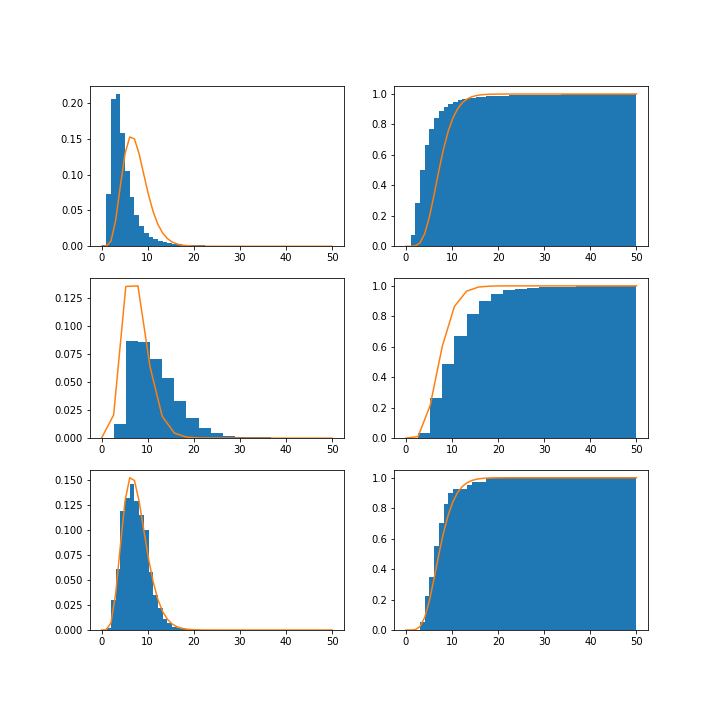

In [104]:
plt.figure(figsize=(10,10))
dof = GC.Ndim
x = np.linspace(0,50,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
plt.subplot(321)
plt.hist(-R2v[:,0],bins = x,density = True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(322)
plt.hist(-R2v[:,0],bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)


x = np.linspace(0,50,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(323)
plt.hist(-R2v[:,1],bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(324)
plt.hist(-R2v[:,1],bins = x,density=True,cumulative=True);
plt.plot(x,cum_chi2)


f_rand = np.random.randn(*f_vec.shape)
LL_rand = 0.5*np.sum(f_rand**2,axis = 1)
x = np.linspace(0,50,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(325)
plt.hist(LL_rand,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(326)
plt.hist(-seizures_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)



<IPython.core.display.Javascript object>


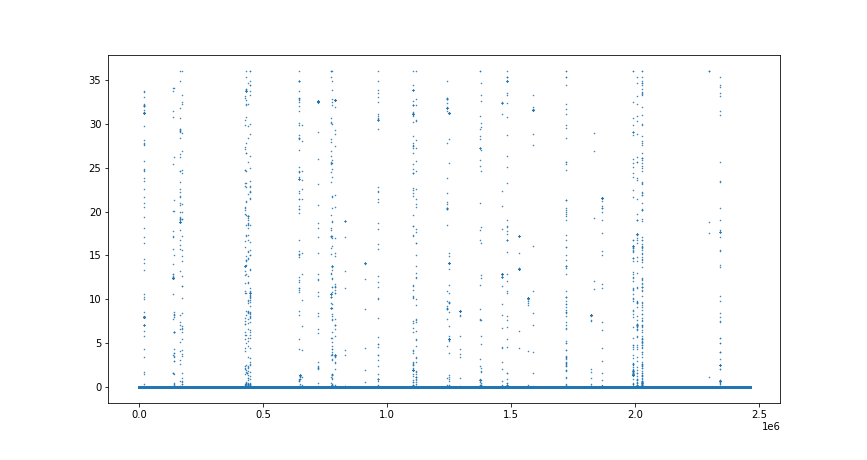

<ipython-input-46-7e7d0c165190>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(1-pf[1,:]),'.', markersize=1)


In [46]:
%matplotlib notebook
plt.figure(figsize=(14,5))
plt.plot(-np.log(1-pf[1,:]),'.', markersize=1)
# plt.ylim(-100,50)

(2461208, 3)

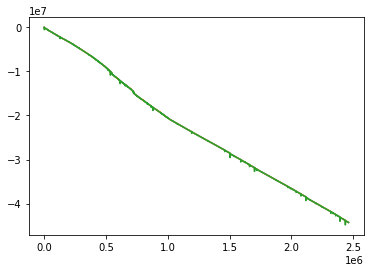

In [71]:
plt.plot(GC.hmm.alpha.T)
# plt.plot(GC.hmm.beta.T)

<IPython.core.display.Javascript object>


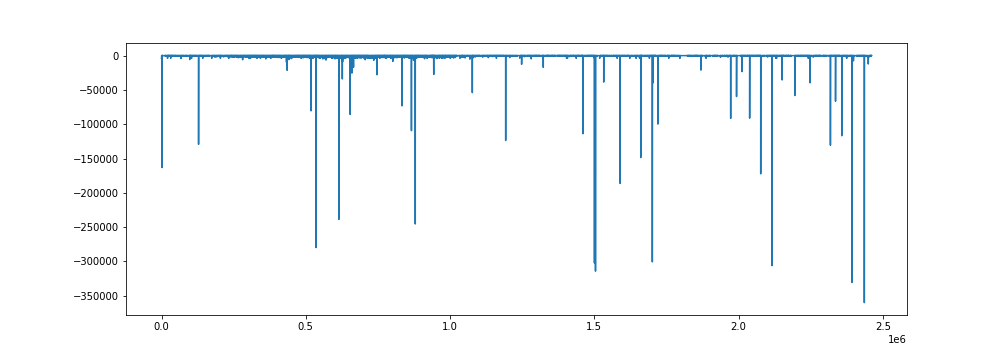

In [115]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.plot(np.where(np.isfinite(LLv[:,1]-LLv[:,0]),np.nan,1),'*')

plt.plot(np.where(np.isfinite(LLv[:,0]),np.nan,20000),'*')
plt.plot(np.where(np.isfinite(LLv[:,1]),np.nan,10000),'*')

In [119]:
_,_,total_npoints = GC.all_mu_and_cov()

In [125]:
 np.log(total_npoints)

15.409253546923276

In [122]:
_,_,total_npoints = GC.all_mu_and_cov()
LLv_reg = np.maximum((np.max(LLv,axis=1) - np.log(total_npoints))[:,np.newaxis],LLv)

<IPython.core.display.Javascript object>


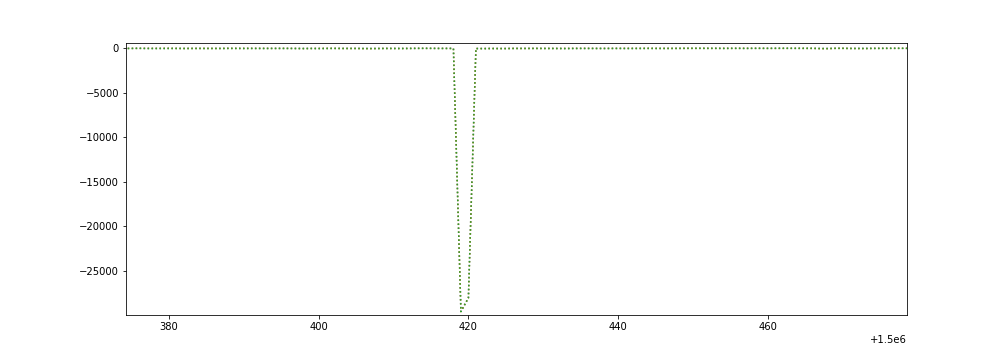

In [129]:
plt.figure(figsize=(14,5))
# plt.plot(LLv, linewidth=.5)
plt.plot(LLv_reg,':')
# plt.ylim(-1000,1000)

In [27]:
print(GC.hmm.A)
print(GC.hmm.phi)

[[9.99997562e-01 2.43796794e-06]
 [4.22535211e-02 9.57746479e-01]]
[[ -247.60718107  -247.51882057  -247.83037244 ...   -12.64143888
    -13.13367215   -60.14581098]
 [-4102.65662991 -4157.71035082 -4092.1385822  ...   -21.2091908
    -20.00942799   -33.10859413]]


In [28]:
GC.hmm.alpha.dtype

dtype('float64')

(-1000.0, 1000.0)

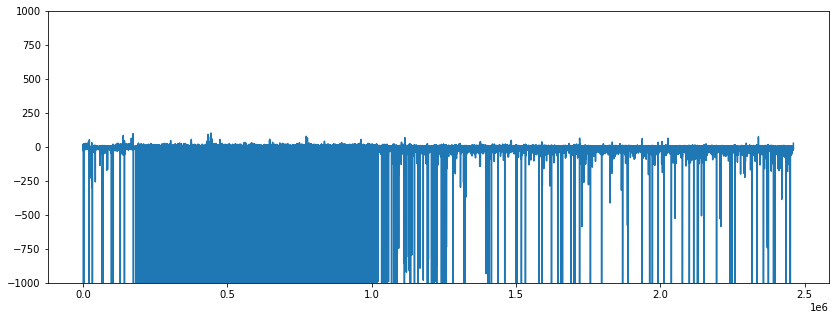

In [29]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.ylim(-1000,1000)

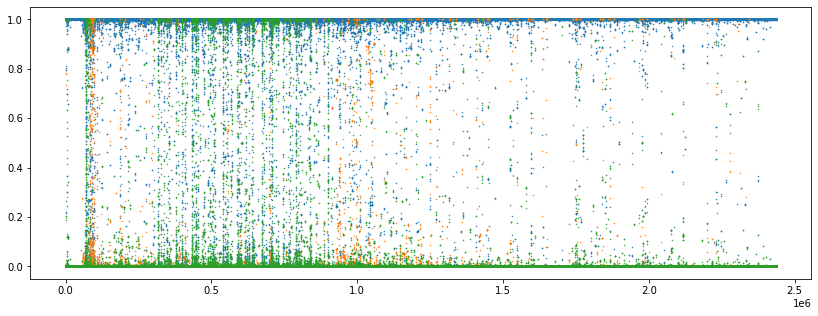

In [21]:
plt.figure(figsize=(14,5))
plt.plot(pf.T,'.', markersize=1)

<ipython-input-20-1aa7656eef08>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(pf.T)-np.log(np.maximum(1-pf.T,1e-12)),'.', markersize=1)


(-100.0, 50.0)

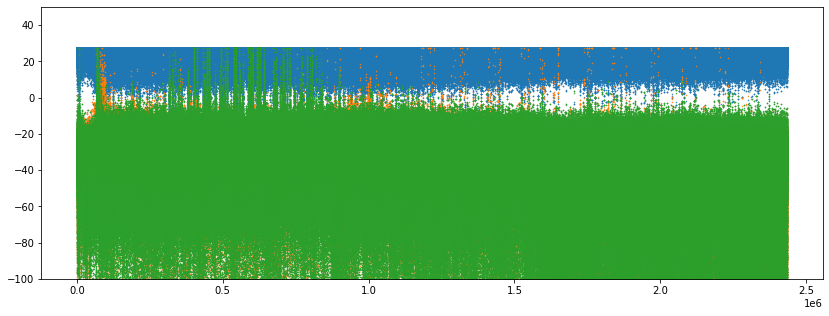

In [20]:
plt.figure(figsize=(14,5))
plt.plot(np.log(pf.T)-np.log(np.maximum(1-pf.T,1e-12)),'.', markersize=1)
plt.ylim(-100,50)

In [32]:
np.log(np.maximum(1-pf.T,1e-12))

array([[-2.76310211e+01,  0.00000000e+00],
       [-2.76310211e+01,  0.00000000e+00],
       [-2.76310211e+01,  0.00000000e+00],
       ...,
       [-1.55306545e+01, -1.79937837e-07],
       [-6.91973280e+00, -9.88582414e-04],
       [-7.42040096e-07, -1.41138629e+01]])

In [152]:
project.current_animal.annotations.labels

['seizure', 'repeated IIEDs', '(auto)seizure']

In [153]:
len(project.current_animal.annotations.annotations_list)

102

In [17]:
project.project_file[:-7]

'/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject_IIEDs'

In [18]:
project.save_to_json(fname = project.project_file[:-7]+'_test.pyecog')

In [149]:
# f_vec_d = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
LL = GC.log_likelyhoods(f_vec,bias=True,no_scale=False)

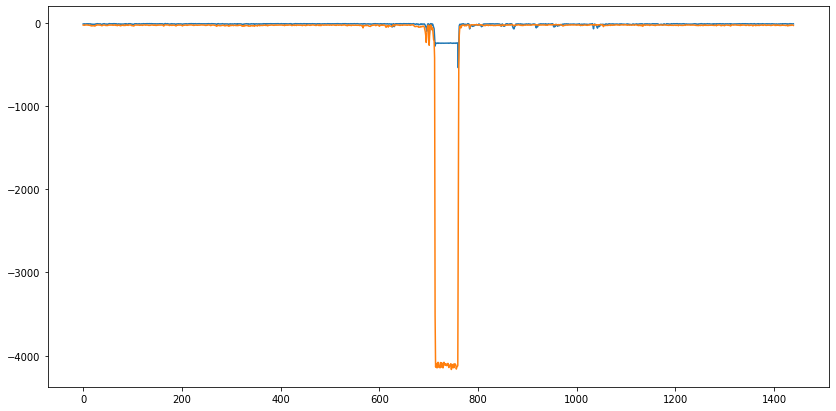

In [150]:
plt.figure(figsize=(14,7))
plt.plot(LL)

In [620]:
print(np.linalg.det(blanks_cov),np.linalg.det(GC.class_cov[0]))

0.000582672948028742 0.28223231073679556


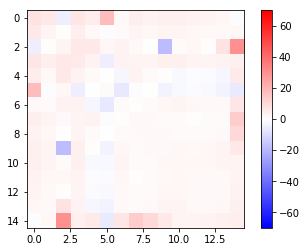

In [621]:
plt.imshow(GC.class_cov[0]/blanks_cov,cmap='bwr',vmin=-70,vmax=70)
plt.colorbar()

In [622]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [623]:
p = LL2prob(LL)

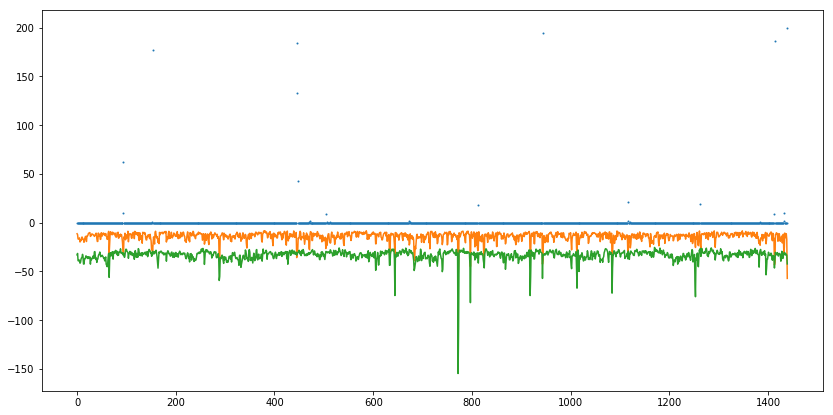

In [624]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

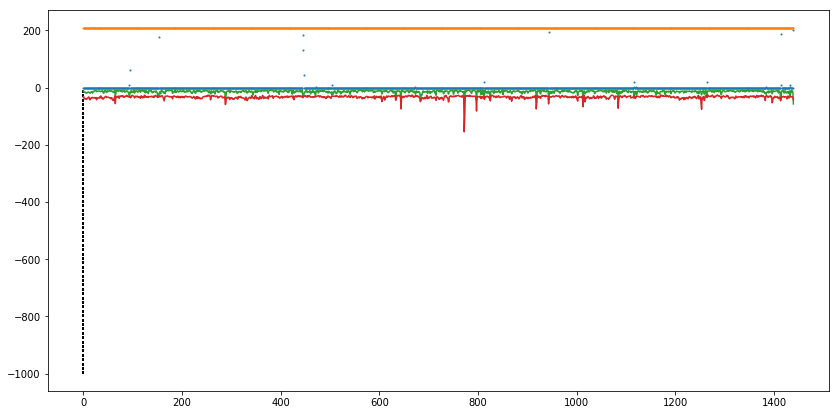

In [625]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(p[:,2]*200+210,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
plt.vlines(starts[1:],-1000,0,linestyles=':')
plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

In [699]:
LLv = []
R2v = []
drawplots = False

project.current_animal.eeg_files.sort()
for eegfname in project.current_animal.eeg_files:
    fname = '.'.join(eegfname.split('.')[:-1]+['features'])
    f_vec = np.fromfile(fname,dtype='float64')
    f_vec = f_vec.reshape((-1,fe.number_of_features))
#     f_vec = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
    LL = GC.log_likelyhoods(f_vec,bias=False,no_scale=False)
    R2 = GC.log_likelyhoods(f_vec,bias=False,no_scale=True)
    LLv.append(LL)
    R2v.append(R2)
    p  = LL2prob(LL) 
    if drawplots:
        plt.figure(figsize=(14,7))
        plt.plot(p[:,1]*200,'.',markersize=2)
        plt.plot(LL[:,0],'.',markersize=2)
        plt.plot(LL[:,1],'.',markersize=2)
        plt.vlines(starts[1:],-1000,0,linestyles=':')
        plt.vlines(ends[1:],-1000,0,linestyles=':')
        plt.title(eegfname)
        plt.show()
    # plt.xlim(400,1000)

    
LLv = np.vstack(LLv)
R2v = np.vstack(R2v)
pv  = LL2prob(LLv) 

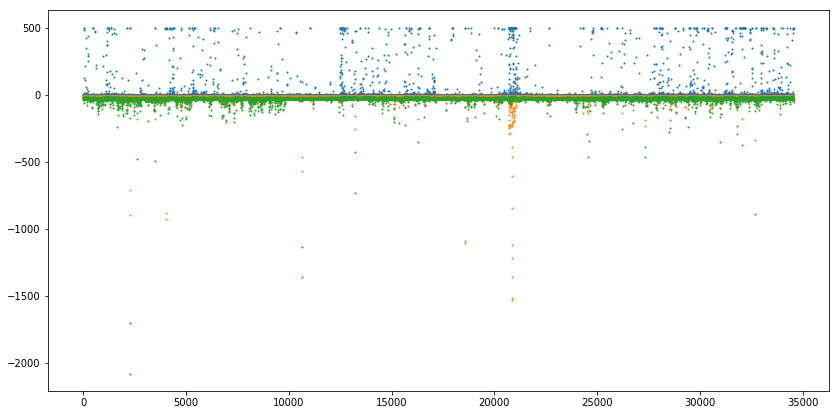

In [700]:
plt.figure(figsize=(14,7))
plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,0],'.',markersize=2)
plt.plot(LLv[:,1],'.',markersize=2)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')

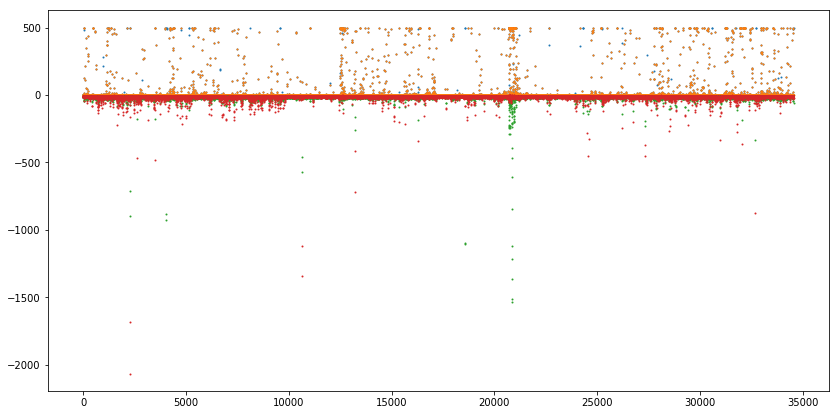

In [701]:
th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.figure(figsize=(14,7))


plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot((pv[:,1]*(-R2v[:,1]<th))*500,'.',markersize=2)
# plt.plot((-R2v[:,1]<th)*500,'-',markersize=2)
plt.plot(R2v[:,0],'.',markersize=2)
plt.plot(R2v[:,1],'.',markersize=2)

In [645]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [646]:
import hmm_pyecog
importlib.reload(hmm_pyecog)

<module 'hmm_pyecog' from '../hmm_pyecog.py'>

In [647]:
# HMM = hmm_pyecog.HMM_LL()
HMM = GC.hmm

In [649]:
HMM.A

array([[9.99956519e-01, 4.34807815e-05, 0.00000000e+00],
       [4.83870968e-02, 9.51612903e-01, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [702]:
p  = LL2prob(LLv).T
pf = HMM.forward_backward(LLv.T)
starts = np.diff(((pf[1,:].T*(-R2v[:,1]<th)))>.5)>0
ends =  np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0

../hmm_pyecog.py:245: RuntimeWarning: divide by zero encountered in log
  alpha[:, 0] = log_phi[:, 0] + np.log(stationary_dist)
../hmm_pyecog.py:249: RuntimeWarning: divide by zero encountered in log
  alpha_t = log_phi[:, t] + np.log(np.dot(exp_alpha_t.T, A))  # sure no undeflow here...
../hmm_pyecog.py:284: RuntimeWarning: divide by zero encountered in log
  beta[:, t] = np.log(beta_t) + max_beta_t


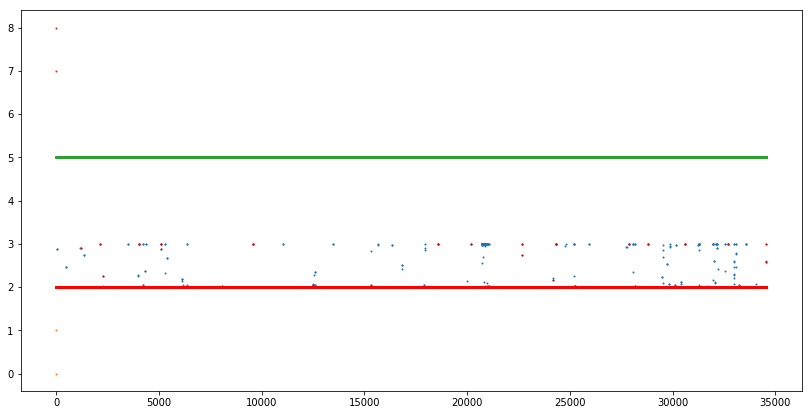

In [753]:
plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot((pf[1,:].T*(-R2v[:,1]>th))+2,'r.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
plt.plot(pf[2,:].T+5,'.',markersize=2)
plt.plot(p[2,:].T+7,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
# plt.xlim(20000,22050)

In [754]:
np.sum(np.diff((pf[1,:]>.5).astype('int')>0))


123

In [755]:
starts = np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))>0)[0]
ends =   np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0)[0]

In [756]:
len(starts)

55

In [757]:
np.tile(np.eye(10),(5,1,1)).shape

(5, 10, 10)

(20600, 21500)

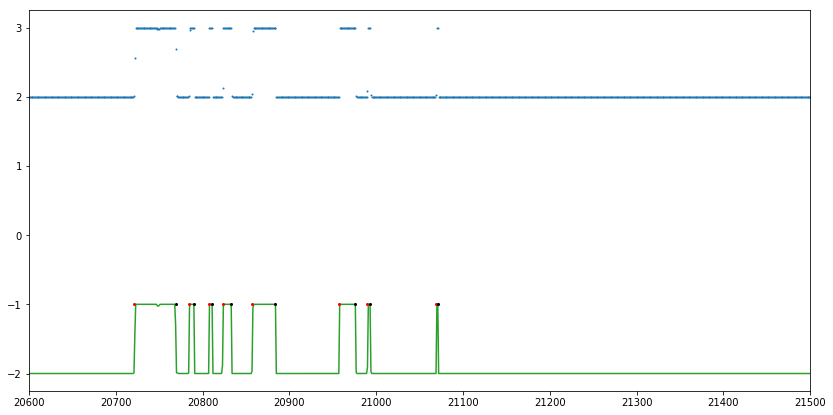

In [759]:
r = (20600,21500)

plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.plot((pf[1,:].T*(-R2v[:,1]<th))-2,'-',markersize=2)
plt.plot(starts,starts*0-1,'o',markersize=2,color='r')
plt.plot(ends,ends*0-1,'o',markersize=2,color='k')
plt.xlim(*r)

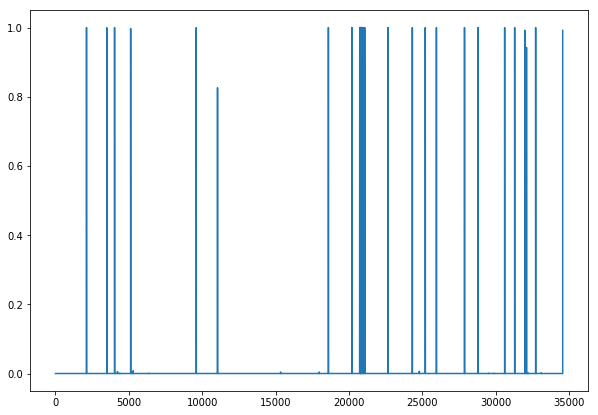

In [125]:
plt.figure(figsize=(10,7))
plt.plot(pf[1,:])
plt.show()

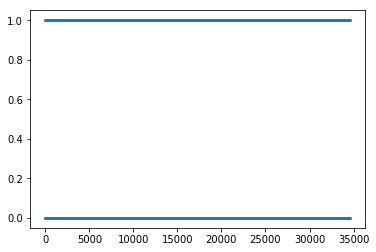

In [126]:
th = stats.chi2.isf(1e-1,15,scale=0.5)
plt.plot((-R2v[:,1]<th),'.',markersize=2)

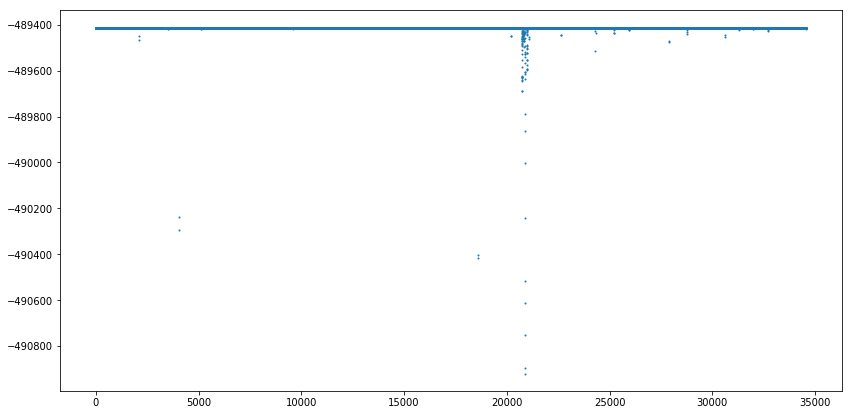

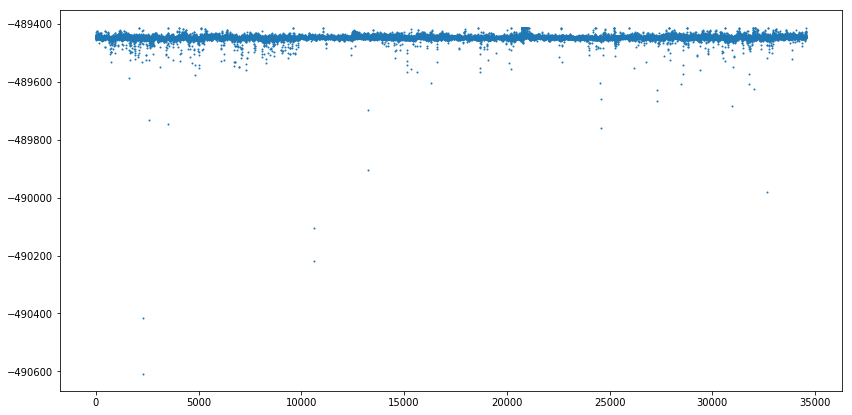

In [127]:

plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[0,:] + HMM.beta[0,:]).T,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[1,:] + HMM.beta[1,:]).T,'.',markersize=2)

(20000, 22000)

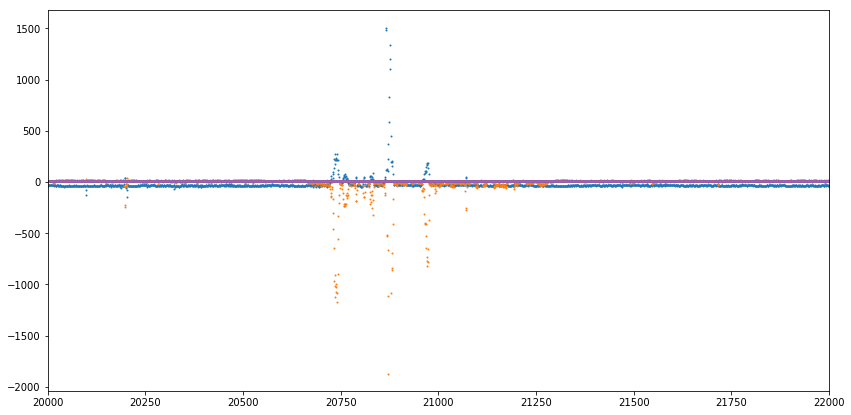

In [128]:
plt.figure(figsize=(14,7))
plt.plot(np.diff(HMM.beta.T+HMM.alpha.T,axis=1),'.',markersize=2)

plt.plot(HMM.posterior.T+10,'.',markersize=2)
plt.xlim(20000,22000)

/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


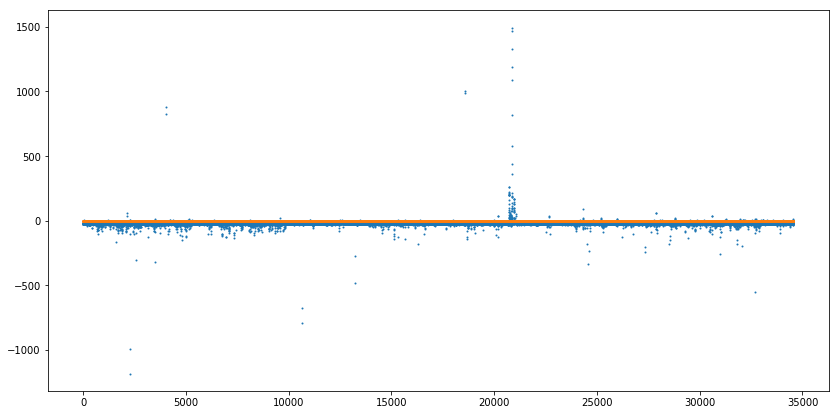

In [129]:
plt.figure(figsize=(14,7))
# plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,1] - LLv[:,0],'.',markersize=2)
plt.plot(np.exp(LLv[:,1] - LLv[:,0])/np.exp(LLv[:,1] - LLv[:,0]),'.',markersize=2)
# plt.plot(LLv[:,1],'.',markersize=2)
# plt.plot(HMM.phi.T,'.',markersize=2)
# plt.xlim(20000,22000)

In [130]:
LLf =(HMM.alpha+HMM.beta).T

In [131]:
dLLf = np.diff(LLf,axis=1)
dLLv = np.diff(LLv,axis=1)

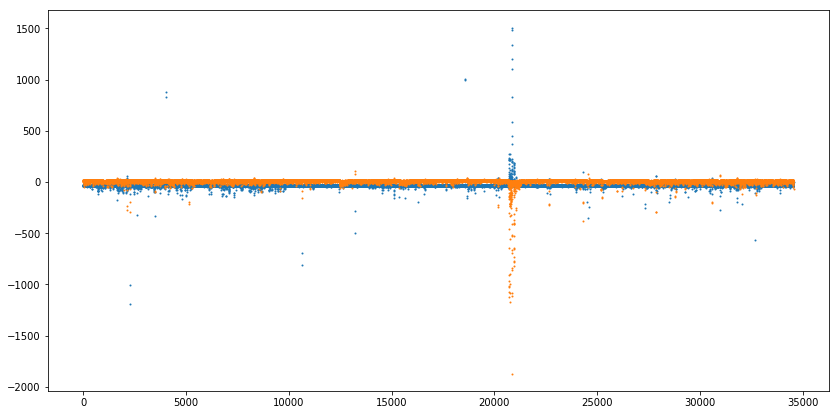

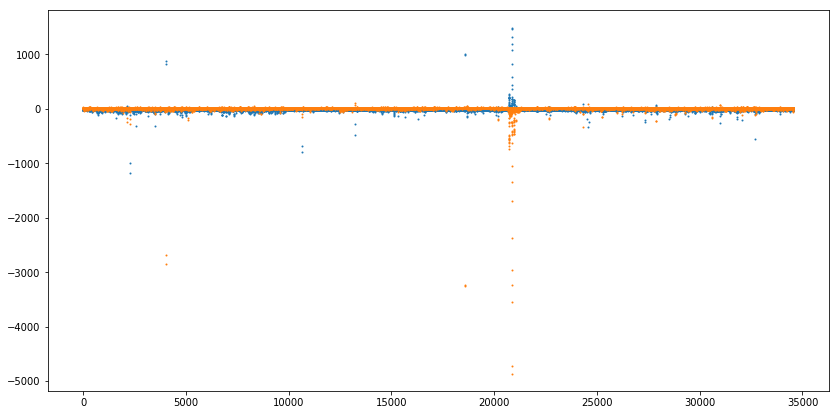

In [132]:
plt.figure(figsize=(14,7))
plt.plot(dLLf,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot(dLLv,'.',markersize=2)

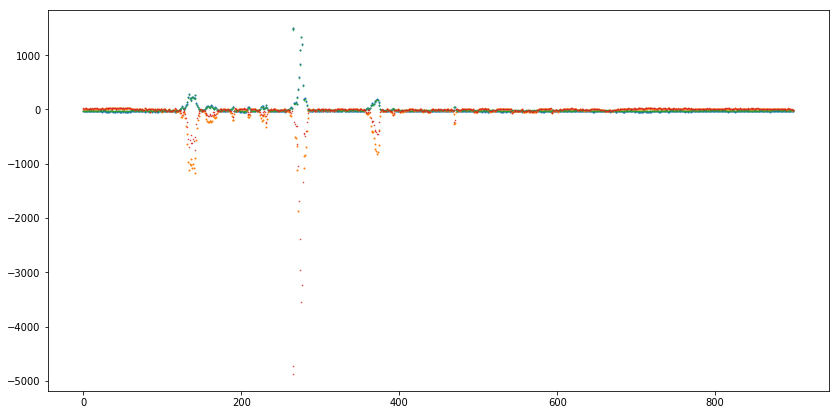

In [133]:
r = range(20600,21500)
plt.figure(figsize=(14,7))
plt.plot(dLLf[r],'.',markersize=2)
plt.plot(dLLv[r],'.',markersize=1)


In [405]:
a = {'b':[[1,2],[6,7]],
     'c':[[2,3],[8,9]]
    }
keys = ['b','c']

In [412]:
d = [(l[0],l[1],i+1) for i,key in enumerate(keys) for l in a[key]]
d

[(1, 2, 1), (6, 7, 1), (2, 3, 2), (8, 9, 2)]

In [413]:
d.sort()
d

[(1, 2, 1), (2, 3, 2), (6, 7, 1), (8, 9, 2)]

In [481]:
dt=.5
def transitions2matrix(t,dt,n):
    A = np.zeros((n+1,n+1))
    A[0,d[0][2]] +=1
    for i in range(len(t)-1):
        if t[i][1] >= t[i+1][0]-dt: # transitions between labled events
            A[t[i][2],t[i+1][2]] +=1
        else:  # transitions between labled events and blanks
            A[t[i][2],0]   +=1
            A[0,t[i+1][2]] += 1
    return A

def tansitions2rates(B,nblankpoints,nclasspoints):
    A = B
    A[0,0] = nblankpoints - np.sum(A[0,:])
    A[0,:] /= np.sum(A[0,:])
    for i in range(len(nclasspoints)):
        if nclasspoints[i]:
            A[i+1,i+1] = nclasspoints[i] - np.sum(A[i+1,:])
            A[i+1,:] /= np.sum(A[i+1,:])
        else: # For classes that do not occur, default to transition to blanks
            A[i+1,:] = 0
            A[i+1,0] = 1
    return A

In [482]:
A = np.zeros((3,3),dtype='float64')
A = transitions2matrix(d,.5,3)

In [483]:
B  = tansitions2rates(A,100,[10,5,0])

In [484]:
B

array([[0.97, 0.02, 0.01, 0.  ],
       [0.1 , 0.8 , 0.1 , 0.  ],
       [0.2 , 0.  , 0.8 , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

In [661]:
tv = []
for i in range(10):
    t =np.arange(100)
    tv.append(t)
tvs = np.hstack(tv)

In [662]:
tvs.shape

(1000,)

In [3]:
6//10

0

In [4]:
1.58496687e+09

1584966870.0

In [5]:
1572565228.494363 + 3600

1572568828.494363

In [198]:
any([False, True, False])

True

In [79]:
def intervals_overlap(a,b):
    return (a[0] <= b[0] < a[1]) or (a[0] <= b[1] < a[1]) or (b[0] <= a[0] < b[1]) or (b[0] <= a[1] < b[1])



In [80]:
manual_label_positions = [[0,.5],[3,4],[7,8]]

In [83]:
if not any([intervals_overlap([.1,2],pos) for pos in manual_label_positions]):
    print('do it')
else:
    print('skip it')


skip it


In [101]:
t = np.linspace(-5,5,1000)

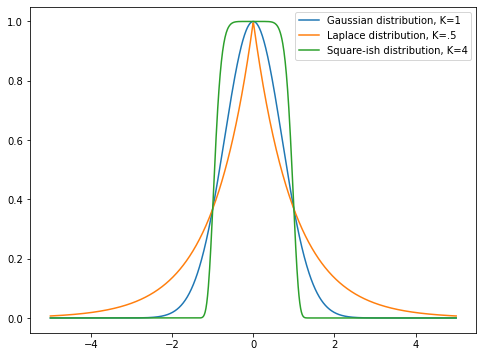

In [128]:
plt.figure(figsize=(8,6))
plt.plot(t,np.exp(-abs(t**2)),label='Gaussian distribution, K=1')
plt.plot(t,np.exp(-abs(t)), label = 'Laplace distribution, K=.5')
plt.plot(t,np.exp(-abs(t)**8), label = 'Square-ish distribution, K=4')
plt.legend()

In [121]:
np.sqrt(np.sum(np.exp(-abs(t))*t**2)/np.sum(np.exp(-abs(t))))

1.3279185502105746

In [125]:
np.sqrt(np.sum(np.exp(-abs(t)**2)*(t**2))/np.sum(np.exp(-abs(t)**2)))

0.707106781160182

In [129]:
animal = project.animal_list[0]

In [160]:
for animal in project.animal_list:
    seiz = 0
    seiz_ele = 0 
    for a in animal.annotations.annotations_list:
        if a.getLabel()=='seizure(ELE)':
            seiz_ele +=1
            for a2 in animal.annotations.annotations_list:
                if a2.getLabel()=='seizure(ELE)':
                    if a is not a2 and intervals_overlap(a.getPos(),a2.getPos()):
                        animal.annotations.delete_annotation(a2)
        if a.getLabel()=='seizure':
            seiz +=1
            for a2 in animal.annotations.annotations_list:
                if a2.getLabel()=='seizure':
                    if a is not a2 and intervals_overlap(a.getPos(),a2.getPos()):
                        animal.annotations.delete_annotation(a2)
                    
    print(animal.id,f' {seiz=},{seiz_ele=}')

119  seiz=81,seiz_ele=81
120  seiz=130,seiz_ele=130
141  seiz=17,seiz_ele=17
17  seiz=71,seiz_ele=71
28  seiz=133,seiz_ele=133
33  seiz=226,seiz_ele=226
35  seiz=38,seiz_ele=38


In [167]:
d = {}
for animal in project.animal_list:
    seiz = 0
    seiz_ele = 0 
    for a in animal.annotations.annotations_list:
        if a.getLabel()=='seizure(ELE)':
            seiz_ele +=1
            for a2 in animal.annotations.annotations_list:
                if a2.getLabel()=='seizure(ELE)':
                    if a is not a2 and intervals_overlap(a.getPos(),a2.getPos()):
                        animal.annotations.delete_annotation(a2)
        if a.getLabel()=='seizure':
            seiz +=1
            for a2 in animal.annotations.annotations_list:
                if a2.getLabel()=='seizure':
                    if a is not a2 and intervals_overlap(a.getPos(),a2.getPos()):
                        animal.annotations.delete_annotation(a2)
                        
for animal in project.animal_list:
    seiz = 0
    seiz_ele = 0 
    for a in animal.annotations.annotations_list:
        if a.getLabel()=='seizure(ELE)':
            seiz_ele +=1
        if a.getLabel()=='seizure':
            seiz +=1
    d[animal.id]= seiz
    print(animal.id,f' {seiz=},{seiz_ele=}')

119  seiz=81,seiz_ele=81
120  seiz=130,seiz_ele=130
141  seiz=17,seiz_ele=17
17  seiz=71,seiz_ele=71
28  seiz=133,seiz_ele=133
33  seiz=226,seiz_ele=226
35  seiz=39,seiz_ele=39


In [131]:
a = animal.annotations.annotations_list[0]

In [133]:
a.getLabel()

'seizure(ELE)'

In [158]:
project.load_from_json('/media/mfpleite/LaCie_1/ML_pyecog_2/ClassifierCVProject.pyecog')

looking for 35
ProjectClass set_current_animal start
AnnotationPage copy_from start
['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', '(auto)seizure', 'seizure']
copy from - history reset
AnnotationPage copy_from finished in 0.0025683970015961677 seconds
AnnotationPage copy_from start
['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', '(auto)seizure', 'seizure']
copy from - history reset
AnnotationPage copy_from finished in 0.0021341399988159537 seconds
ProjectClass set_current_animal ran in 0.004889707997790538 seconds
current animal: 35


In [164]:
project.load_from_json('/media/mfpleite/LaCie_1/ML_pyecog_2/ClassifierCVProject_LabMeeting.pyecog')

looking for 35
ProjectClass set_current_animal start
AnnotationPage copy_from start
['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', '(auto)seizure', 'seizure']
copy from - history reset
AnnotationPage copy_from finished in 0.00172731900238432 seconds
AnnotationPage copy_from start
['seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming', '(auto)seizure', 'seizure']
copy from - history reset
AnnotationPage copy_from finished in 0.0029838600021321326 seconds
ProjectClass set_current_animal ran in 0.004849078992265277 seconds
current animal: 35


In [168]:
d0 = {
    '17':70,
    '141':17,
    '120':126,
    '119':81,
    '35':39,
    '33':223,
    '28':130
}

In [169]:
d

{'119': 81, '120': 130, '141': 17, '17': 71, '28': 133, '33': 226, '35': 39}

In [172]:
total0 = 0
total  = 0
for key in d0.keys():
    total+=d[key]
    total0+=d0[key]
    print(key,d0[key],d[key])
    

17 70 71
141 17 17
120 126 130
119 81 81
35 39 39
33 223 226
28 130 133


In [173]:
total0,total

(686, 697)